<a href="https://colab.research.google.com/github/Motunrayo244/EDISS-MP/blob/main/MachineLearning/MiniProject3/Mini_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition Using Smartphones Dataset


"The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data."

For more information about the dataset, read the "human_activity_recognitionsmartphones/UCI HAR Dataset.names" file ater executing the cell below.


In [1]:
# This cell downloads the dataset and unzip it to the folder
! wget -nc https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip
! unzip -q -o human+activity+recognition+using+smartphones.zip -d human_activity_recognitionsmartphones
! pwd
! unzip -q -o "./human_activity_recognitionsmartphones/UCI HAR Dataset.zip"
! rm -rf __MACOSX/

--2024-03-10 18:28:16--  https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘human+activity+recognition+using+smartphones.zip’

human+activity+reco     [         <=>        ]  58.18M  30.1MB/s    in 1.9s    

2024-03-10 18:28:18 (30.1 MB/s) - ‘human+activity+recognition+using+smartphones.zip’ saved [61005872]

/content


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from time import time



## Dataset and Dataset Information

The section analyses the data and the discusses the feature selection process that was used for the model training on the raw dataset.
For this project, four main files from the dataset were used. The files used were the X_train.txt, y_train.txt, X_test.txt, and y_test.txt and they made up the of training and testing set respectively. The y_train and y_test files were used for visualization and analysis while the X_train, and X_test was used to train the clustering algorithm.


In [3]:
activity_dict = {1: 'WALKING', 2: "WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4: "SITTING", 5: "STANDING", 6: "LAYING"}

In [4]:
feature_columns = pd.read_csv('UCI HAR Dataset/features.txt',sep = '\s+',
                                 header = None,
                                 names = ['column_index', 'column_name'])

In [5]:
duplicated =feature_columns[ feature_columns['column_name'].duplicated(keep=False)]
print(f" There are {duplicated.shape[0]} duplicate feature names")

 There are 126 duplicate feature names


In [6]:
# to take care of duplicate rows we appened a duplicate counter column to the duplicated colum and rename the columns.
feature_columns['dup_cnt'] = feature_columns.groupby('column_name').cumcount()

In [7]:
feature_columns['column_name'] = feature_columns.apply(lambda x:
                                                       f"{x['column_name'].replace(',', '_').replace('-', '_').replace('()', '')}_{x['dup_cnt']}"
                                                       if x['dup_cnt'] > 0
                                                       else x['column_name'].replace(',', '_').replace('-', '_').replace('()', ''),
                                                       axis=1)

In [8]:
duplicated =feature_columns[ feature_columns['column_name'].duplicated(keep=False)]
print(f" There are {duplicated.shape[0]} duplicate feature names")

 There are 0 duplicate feature names


In [9]:
features = list(feature_columns['column_name'])
len(features)

561

In [10]:
sub_train = pd.read_csv("UCI HAR Dataset/train/subject_train.txt", names=['subject'], header=None, delim_whitespace=True )
sub_test = pd.read_csv("UCI HAR Dataset/test/subject_test.txt", names= ['subject'], header=None, delim_whitespace=True)
#combine both train and test data
full_sub_data = pd.concat([sub_train,sub_test], ignore_index=True, axis=0)

In [11]:
train_data = pd.read_csv("UCI HAR Dataset/train/X_train.txt", names=features, header=None, delim_whitespace=True )
test_data = pd.read_csv("UCI HAR Dataset/test/X_test.txt", names=features, header=None, delim_whitespace=True)
#combine both train and test data
full_data = pd.concat([train_data,test_data], ignore_index=True, axis=0)

In [12]:
# Import the labels for EDA and visualisation
train_y = pd.read_csv("UCI HAR Dataset/train/y_train.txt", names=['label_'], header=None, delim_whitespace=True )
test_y = pd.read_csv("UCI HAR Dataset/test/y_test.txt", names=['label_'], header=None, delim_whitespace=True)
full_data_y = pd.concat([train_y,test_y], ignore_index=True, axis=0)

In [13]:
#convert label ecodings to strings
full_data_y['label'] = full_data_y['label_'].apply(lambda x: activity_dict[x])


In [14]:
print(f' Train dataset has {train_data.shape[0]} rows {train_data.shape[1]} columns')
print(f' Test dataset has {test_data.shape[0]} rows {test_data.shape[1]} columns')
print(f' Full dataset has {full_data.shape[0]} rows {full_data.shape[1]} columns')
print(f' Full dataset y has {full_data_y.shape[0]} rows {full_data_y.shape[1]} columns')


 Train dataset has 7352 rows 561 columns
 Test dataset has 2947 rows 561 columns
 Full dataset has 10299 rows 561 columns
 Full dataset y has 10299 rows 2 columns


In [15]:
train_data.head()

tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
0         0.288585        -0.020294        -0.132905       -0.995279   
1         0.278419        -0.016411        -0.123520       -0.998245   
2         0.279653        -0.019467        -0.113462       -0.995380   
3         0.279174        -0.026201        -0.123283       -0.996091   
4         0.276629        -0.016570        -0.115362       -0.998139   

   tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
0       -0.983111       -0.913526       -0.995112       -0.983185   
1       -0.975300       -0.960322       -0.998807       -0.974914   
2       -0.967187       -0.978944       -0.996520       -0.963668   
3       -0.983403       -0.990675       -0.997099       -0.982750   
4       -0.980817       -0.990482       -0.998321       -0.979672   

   tBodyAcc_mad_Z  tBodyAcc_max_X  ...  fBodyBodyGyroJerkMag_meanFreq  \
0       -0.923527       -0.934724  ...                      -0.074323   
1       -0.957686       -0.943068  ...                       0.158075   
2       -0.977469       -0.938692  ...                       0.414503   
3       -0.989302       -0.938692  ...                       0.404573   
4       -0.990441       -0.942469  ...                       0.087753   

   fBodyBodyGyroJerkMag_skewness  fBodyBodyGyroJerkMag_kurtosis  \
0                      -0.298676                      -0.710304   
1                      -0.595051                      -0.861499   
2                      -0.390748                      -0.760104   
3                      -0.117290                      -0.482845   
4                      -0.351471                      -0.699205   

   angle(tBodyAccMean_gravity)  angle(tBodyAccJerkMean)_gravityMean)  \
0                    -0.112754                              0.030400   
1                     0.053477                             -0.007435   
2                    -0.118559                              0.177899   
3                    -0.036788                             -0.012892   
4                     0.123320                              0.122542   

   angle(tBodyGyroMean_gravityMean)  angle(tBodyGyroJerkMean_gravityMean)  \
0                         -0.464761                             -0.018446   
1                         -0.732626                              0.703511   
2                          0.100699                              0.808529   
3                          0.640011                             -0.485366   
4                          0.693578                             -0.615971   

   angle(X_gravityMean)  angle(Y_gravityMean)  angle(Z_gravityMean)  
0             -0.841247              0.179941             -0.058627  
1             -0.844788              0.180289             -0.054317  
2             -0.848933              0.180637             -0.049118  
3             -0.848649              0.181935             -0.047663  
4             -0.847865              0.185151             -0.043892  

[5 rows x 561 columns]

In [16]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 561 entries, tBodyAcc_mean_X to angle(Z_gravityMean)
dtypes: float64(561)
memory usage: 44.1 MB


## About the Dataset (Exploratory Data Analysis) EDA
The train and test dataset consists of 7,352 and 2,947 datapoints respectively. The datasets consisted of 561 numerical features. There were no null values in the dataset and all features were normalized to range between -1 to 1. The train and test set were combined in this project and the clustering algorithms were trained on both datasets. The dataset explored consisted of 10, 299 datapoints and 561 features

The y_train and y_test consists of numerical encoded labels (1-6) for the activities being performed for corresponding features set.


> The features in the data set contains highly correlated feature these can be observed in the heatmap with a high percentage of the features having a correlation close to 1 with each other.


> Features like the tbodyAccjerk_mean_z,,and t_bodyGro_energy_x show that the values representing activities that involved walking were different from where the subject was stationary.

> Angle(tBodyGyrojerkMean_gravityMean) and angle(X_gravityMean) distinctively differentiates laying activity from other activities as shown in figure 2.5.









In [17]:
full_data.describe()

tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count     10299.000000     10299.000000     10299.000000    10299.000000   
mean          0.274347        -0.017743        -0.108925       -0.607784   
std           0.067628         0.037128         0.053033        0.438694   
min          -1.000000        -1.000000        -1.000000       -1.000000   
25%           0.262625        -0.024902        -0.121019       -0.992360   
50%           0.277174        -0.017162        -0.108596       -0.943030   
75%           0.288354        -0.010625        -0.097589       -0.250293   
max           1.000000         1.000000         1.000000        1.000000   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count    10299.000000    10299.000000    10299.000000    10299.000000   
mean        -0.510191       -0.613064       -0.633593       -0.525697   
std          0.500240        0.403657        0.413333        0.484201   
min         -1.000000       -1.000000       -1.000000       -1.000000   
25%         -0.976990       -0.979137       -0.993293       -0.977017   
50%         -0.835032       -0.850773       -0.948244       -0.843670   
75%         -0.057336       -0.278737       -0.302033       -0.087405   
max          1.000000        1.000000        1.000000        1.000000   

       tBodyAcc_mad_Z  tBodyAcc_max_X  ...  fBodyBodyGyroJerkMag_meanFreq  \
count    10299.000000    10299.000000  ...                   10299.000000   
mean        -0.614989       -0.466732  ...                       0.126708   
std          0.399034        0.538707  ...                       0.245443   
min         -1.000000       -1.000000  ...                      -1.000000   
25%         -0.979064       -0.935788  ...                      -0.019481   
50%         -0.845068       -0.874825  ...                       0.136245   
75%         -0.288149       -0.014641  ...                       0.288960   
max          1.000000        1.000000  ...                       1.000000   

       fBodyBodyGyroJerkMag_skewness  fBodyBodyGyroJerkMag_kurtosis  \
count                   10299.000000                   10299.000000   
mean                       -0.298592                      -0.617700   
std                         0.320199                       0.308796   
min                        -1.000000                      -1.000000   
25%                        -0.536174                      -0.841847   
50%                        -0.335160                      -0.703402   
75%                        -0.113167                      -0.487981   
max                         1.000000                       1.000000   

       angle(tBodyAccMean_gravity)  angle(tBodyAccJerkMean)_gravityMean)  \
count                 10299.000000                          10299.000000   
mean                      0.007705                              0.002648   
std                       0.336591                              0.447364   
min                      -1.000000                             -1.000000   
25%                      -0.124694                             -0.287031   
50%                       0.008146                              0.007668   
75%                       0.149005                              0.291490   
max                       1.000000                              1.000000   

       angle(tBodyGyroMean_gravityMean)  angle(tBodyGyroJerkMean_gravityMean)  \
count                      10299.000000                          10299.000000   
mean                           0.017683                             -0.009219   
std                            0.616188                              0.484770   
min                           -1.000000                             -1.000000   
25%                           -0.493108                             -0.389041   
50%                            0.017192                             -0.007186   
75%                            0.536137                              0.365996 

In [18]:
# confirm no missing values
full_data.isnull().sum().sort_values(ascending=False)[0:5]

tBodyAcc_mean_X            0
fBodyAccJerk_skewness_Y    0
fBodyAccJerk_maxInds_Z     0
fBodyAccJerk_meanFreq_X    0
fBodyAccJerk_meanFreq_Y    0
dtype: int64

<Axes: >

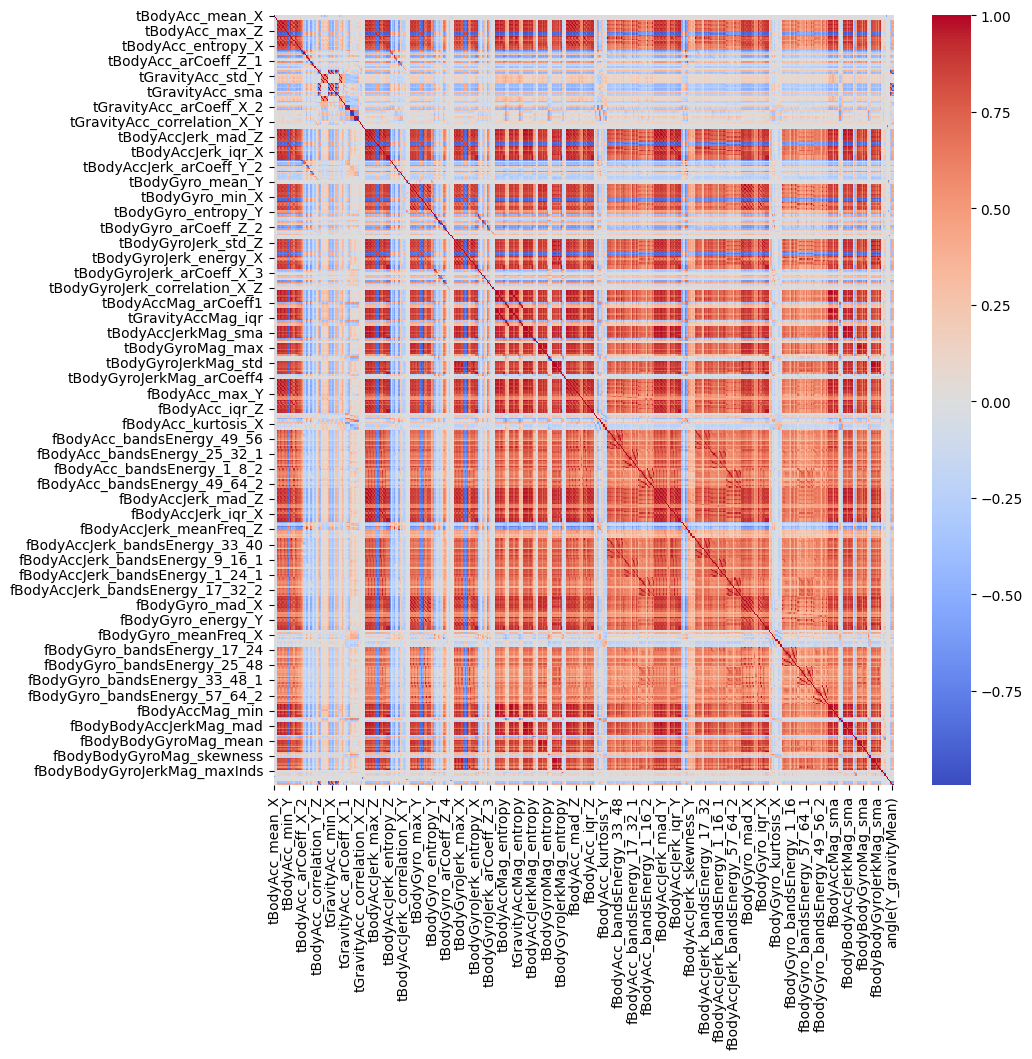

In [19]:
# Heatmap of the correlation of the full dataset
plt.figure(figsize=(10, 10))
sns.heatmap(full_data.corr(), annot=False, cmap='coolwarm')

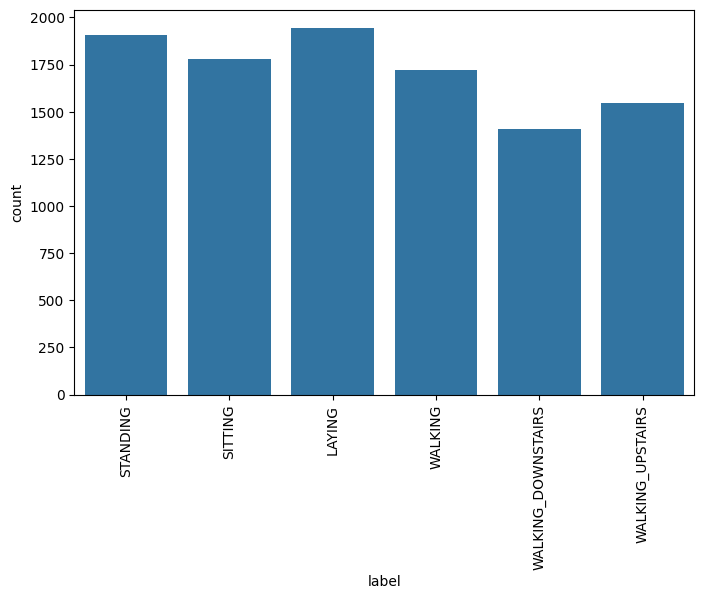

In [20]:
# distribution of the activity label
plt.figure(figsize=(8,5))
axis=sns.countplot(x="label",data=full_data_y)
plt.xticks(x=full_data_y['label'],rotation='vertical')
plt.show()

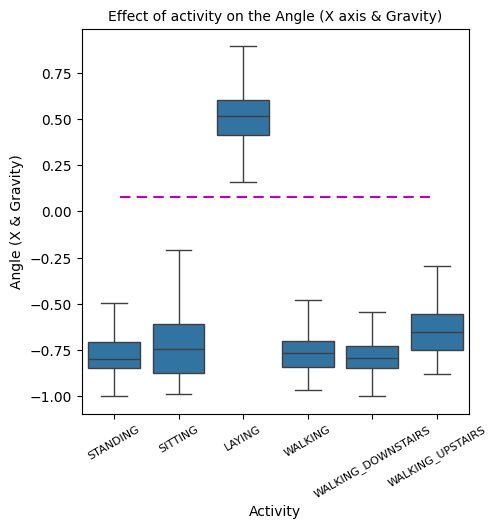

In [21]:
plt.figure(figsize=(5,5))
sns.boxplot(x=full_data_y['label'], y='angle(X_gravityMean)', data=full_data, showfliers=False)
plt.axhline(y=0.08,xmin=0.1,xmax=0.9,c='m',dashes=(5,3))
plt.title('Effect of activity on the Angle (X axis & Gravity)', fontsize=10)
plt.xlabel("Activity", size=10)
plt.ylabel('Angle (X & Gravity)', size=10)
plt.xticks(rotation=30,fontsize=8)
plt.show()

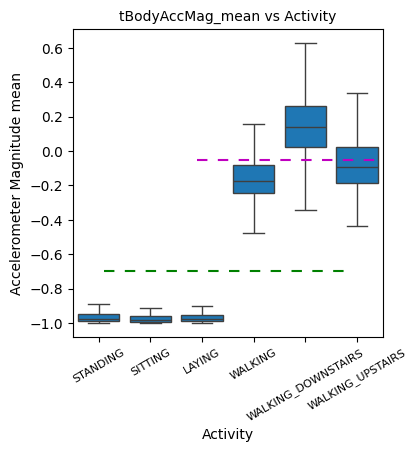

In [22]:
plt.figure(figsize=(4,4))
sns.boxplot(x=full_data_y['label'], y='tBodyAccMag_mean',data=train_data, showfliers=False, saturation=1)
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.title("tBodyAccMag_mean vs Activity", fontsize = 10)
plt.xlabel("Activity", size=10)
plt.ylabel('Accelerometer Magnitude mean', size=10)
plt.xticks(rotation=30, fontsize=8)
plt.show()

In [23]:
tBodyAcc_features = [x for x in features if x.startswith('tBodyAcc')]
tBodyGyro_features = [x for x in features if x.startswith('tBodyGyro')]
tGravityAcc_features = [x for x in features if x.startswith('tGravityAcc')]
fBodyAcc_features = [x for x in features if x.startswith('fBodyAcc')]
fBodyGyro_features = [x for x in features if x.startswith('fBodyGyro')]
fBodyBodyAcc_features = [x for x in features if x.startswith('fBodyBodyAcc')]
fBodyBodyGyro_features = [x for x in features if x.startswith('fBodyBodyGyro')]
angle_features = [x for x in features if x.startswith('angle')]

In [24]:
len(tBodyAcc_features)+ len(tBodyGyro_features) + len(tGravityAcc_features)+len(fBodyAcc_features)+ len(fBodyGyro_features)+len(fBodyBodyAcc_features)+ len(fBodyBodyGyro_features)+len(angle_features)

561

In [25]:
len(angle_features)

7

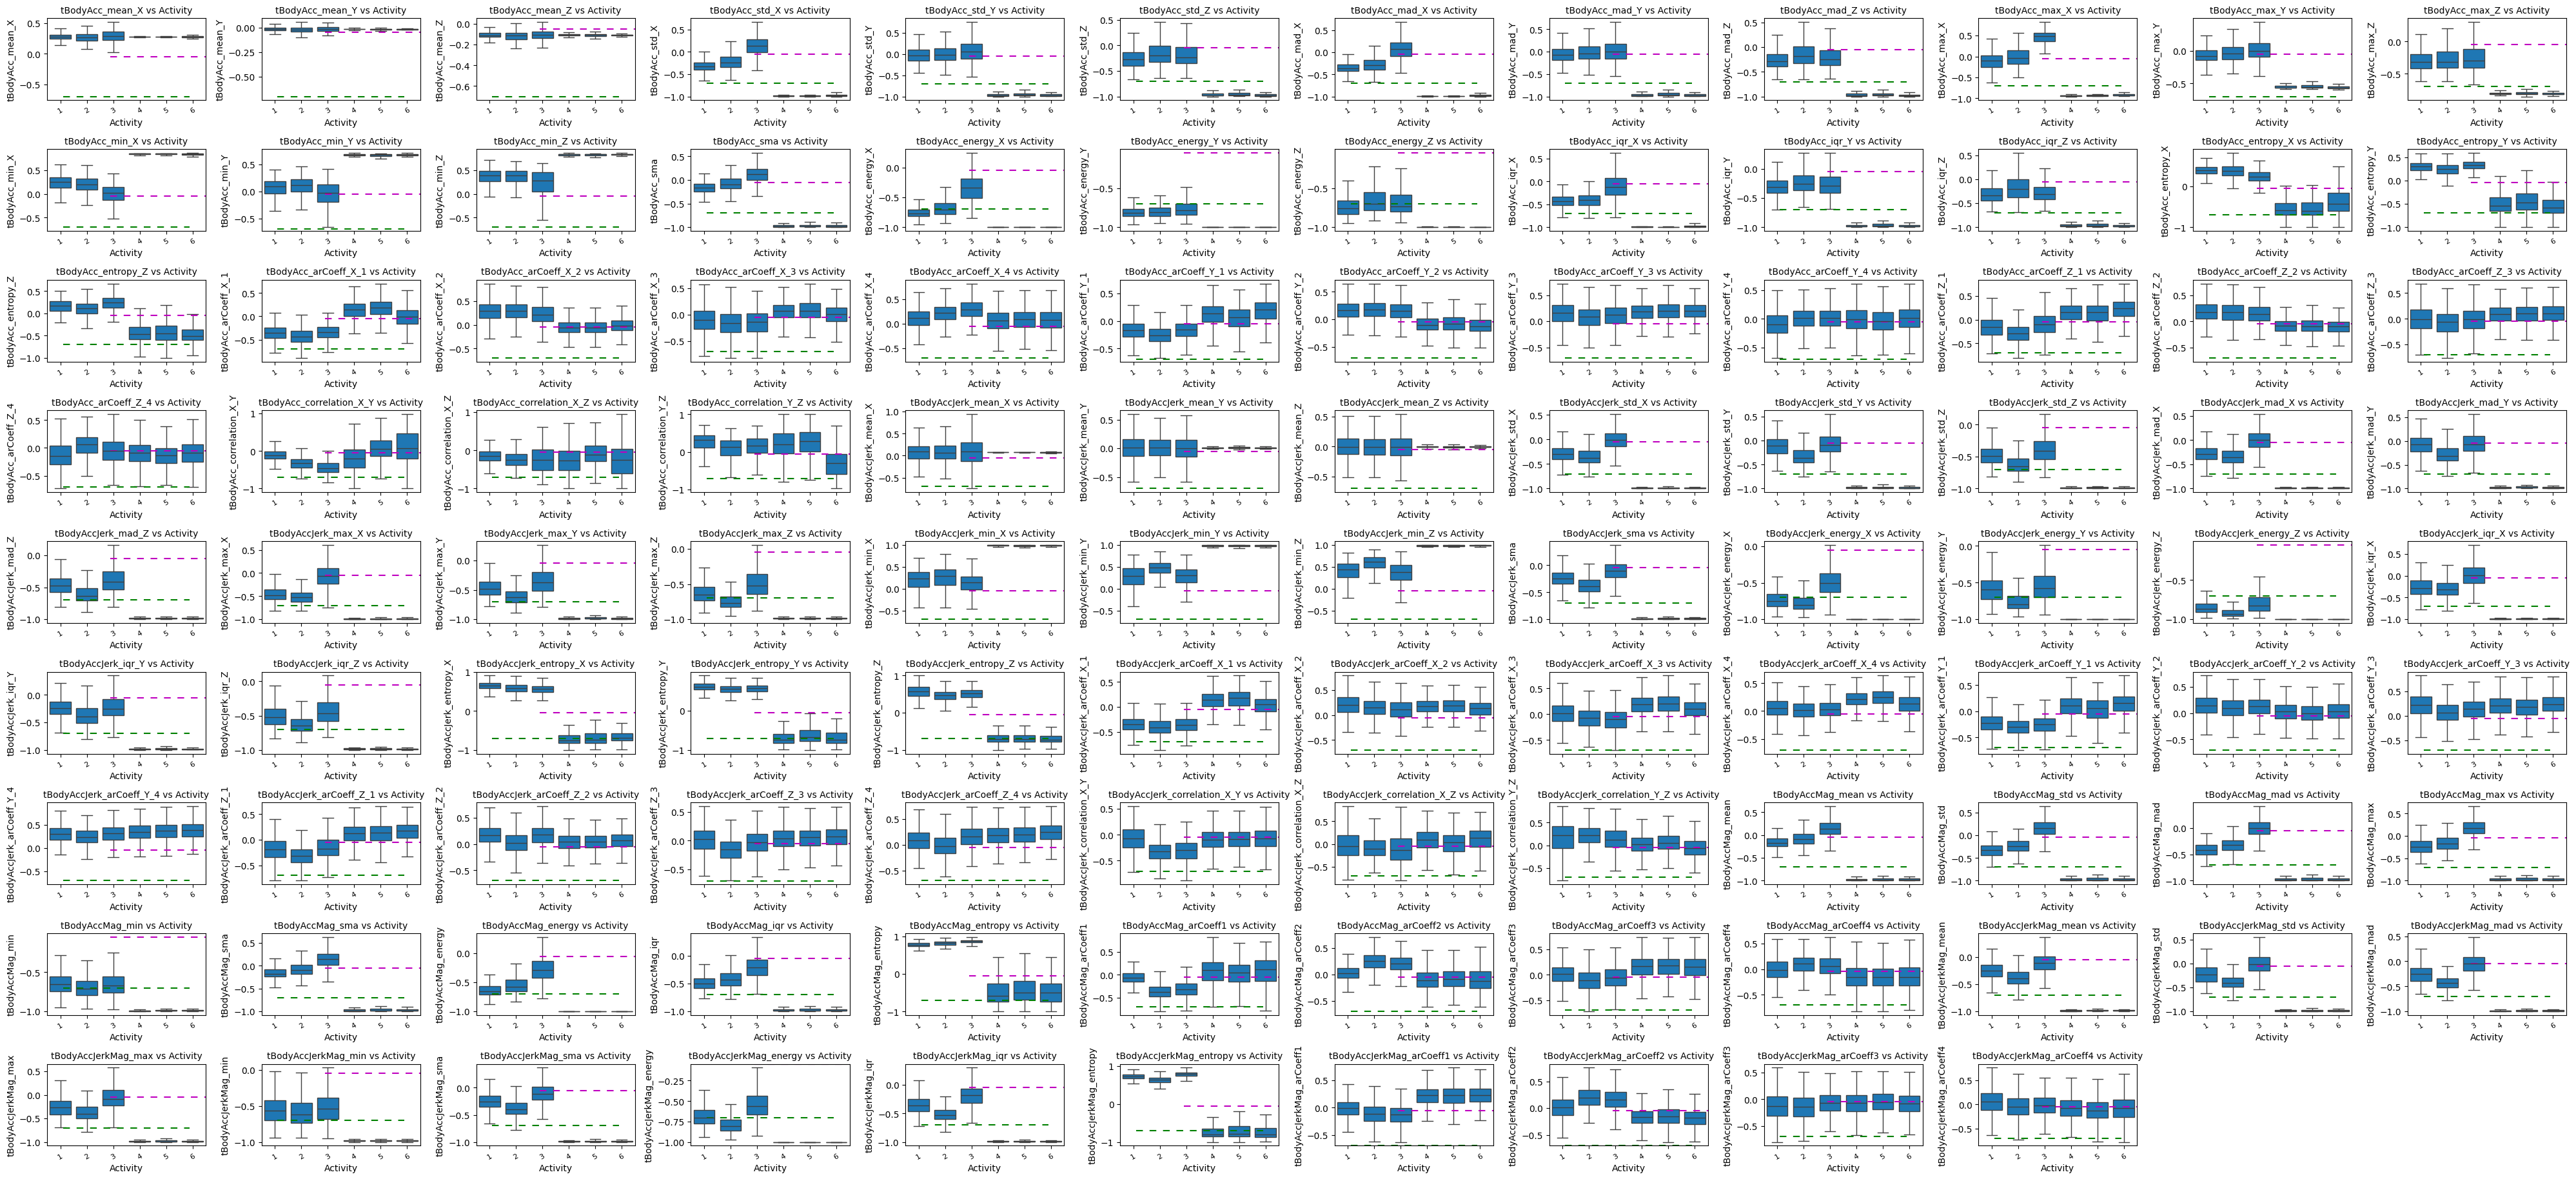

In [26]:
# Number of rows and columns for the subplot grid
n_rows = 10
n_cols = 12
# custom_colors = {'1': 'orange', '2': 'green', '3': 'red', '4': 'yellow', '5':'cyan','6':'black'}
plt.figure(figsize=(40,20))
for i,col in enumerate(tBodyAcc_features,1):
  plt.subplot(n_rows, n_cols, i)
  sns.boxplot(x=full_data_y['label_'], y= col,data=train_data, showfliers=False, saturation=1)

  plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
  plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
  plt.title(f"{col} vs Activity", fontsize = 10)
  plt.xlabel("Activity", size=10)
  plt.ylabel(f'{col}', size=10)
  plt.xticks(rotation=30, fontsize=8)
  plt.tight_layout()
plt.show()

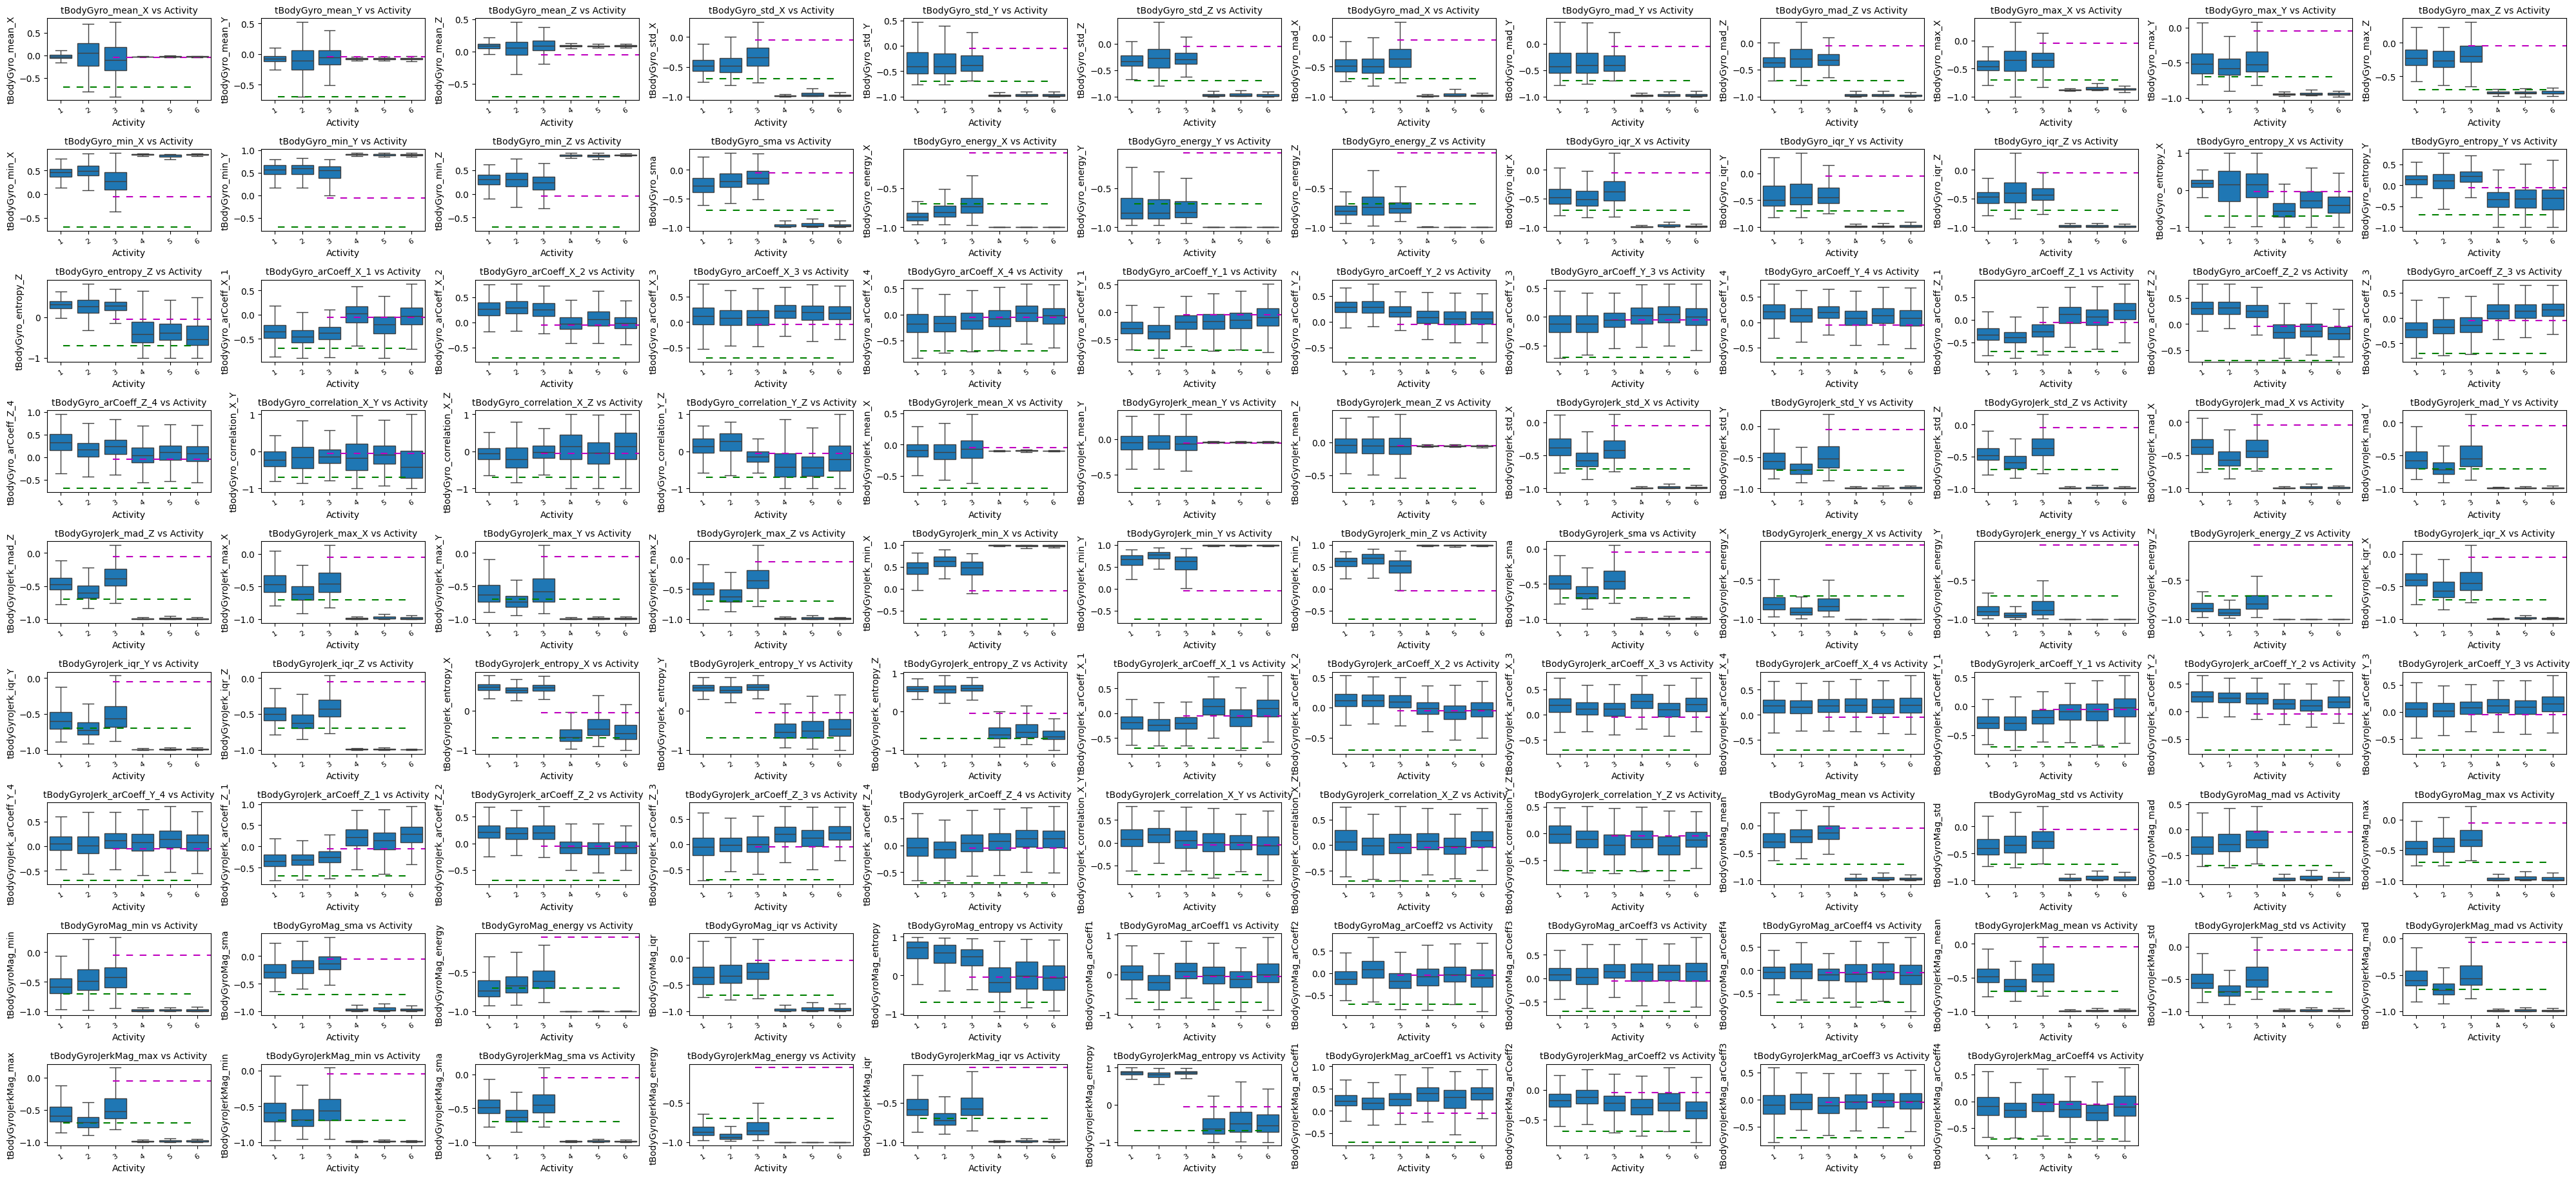

In [27]:
# Number of rows and columns for the subplot grid
n_rows = 10
n_cols = 12
custom_colors = {'1': 'orange', '2': 'green', '3': 'red', '4': 'yellow', '5':'cyan','6':'black'}
plt.figure(figsize=(40,20))
for i,col in enumerate(tBodyGyro_features,1):
  plt.subplot(n_rows, n_cols, i)
  sns.boxplot(x=full_data_y['label_'], y= col,data=train_data, showfliers=False, saturation=1)

  plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
  plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
  plt.title(f"{col} vs Activity", fontsize = 10)
  plt.xlabel("Activity", size=10)
  plt.ylabel(f'{col}', size=10)
  plt.xticks(rotation=30, fontsize=8)
  plt.tight_layout()
plt.show()

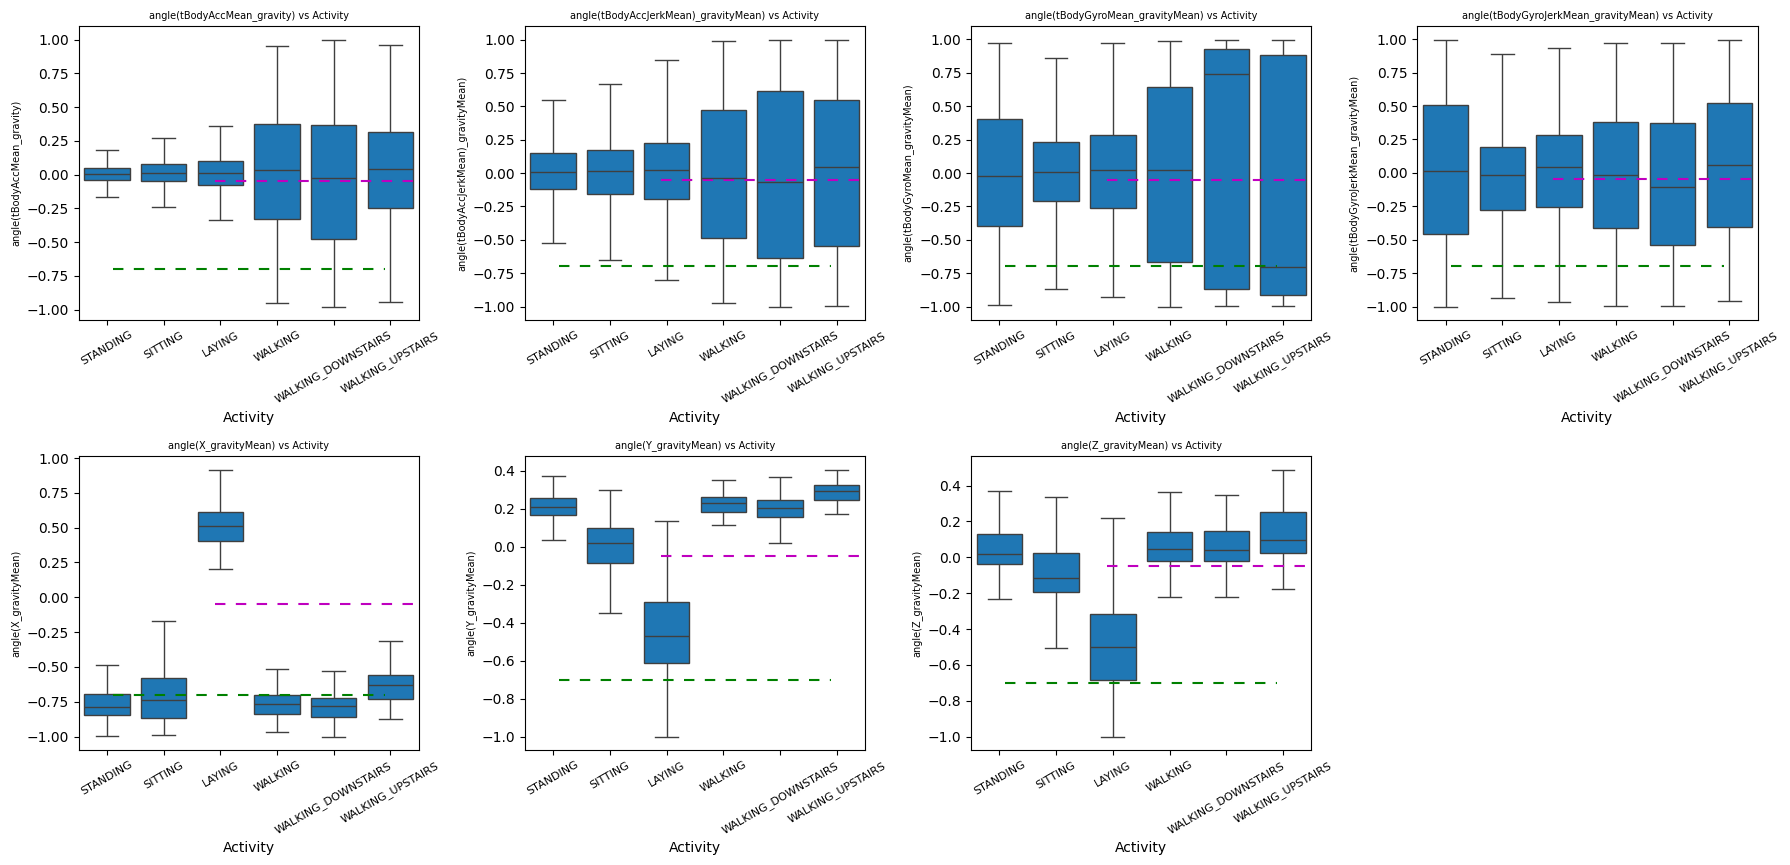

In [28]:
# Number of rows and columns for the subplot grid
n_rows = 3
n_cols = 4

plt.figure(figsize=(18,12))
for i,col in enumerate(angle_features,1):
  plt.subplot(n_rows, n_cols, i)
  sns.boxplot(x=full_data_y['label'], y= col,data=train_data, showfliers=False, saturation=1)

  plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
  plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
  plt.title(f"{col} vs Activity", fontsize = 7)
  plt.xlabel("Activity", size=10)
  plt.ylabel(f'{col}', size=7)
  plt.xticks(rotation=30, fontsize=8)
  plt.tight_layout()
plt.show()

#### Feature Selection

From the EDA (the heat map), it is noticable that the features in the dataset are highly corellated.

To reduce the dimension in the dataset, the dimensions was reduced by removing features that had correlation lower than 0.4 with the activity label. The features were further reduced by removing columns with a variation below 0.1.

Text(0.5, 0, 'corellation')

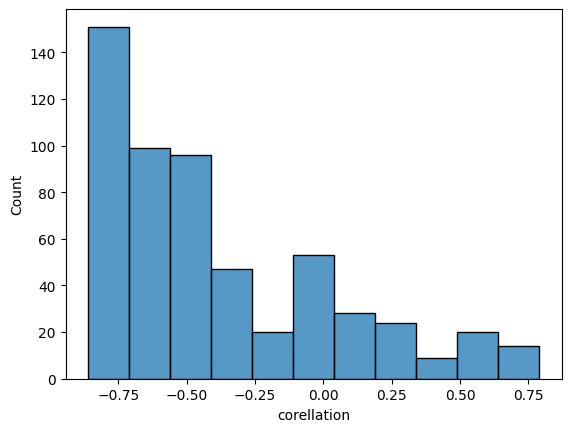

In [29]:
correlations = full_data.corrwith(full_data_y['label_'])
sns.histplot(x=correlations)
plt.xlabel("corellation", size=10)


Text(0.5, 0, 'variance')

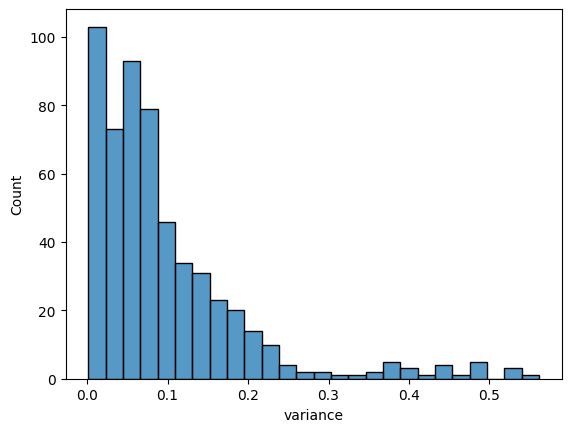

In [30]:
variances = full_data.var()
sns.histplot(x=variances)
plt.xlabel("variance", size=10)


In [31]:
variance_threshold = 0.2
correlation_threshold = 0.4

# Correlation Threshold
correlations = full_data.corrwith(full_data_y['label_'])
high_correlation_columns = correlations[abs(correlations) > correlation_threshold].index
df_filtered = full_data[high_correlation_columns]

# Variance Threshold
variances = df_filtered.var()
high_variance_columns = variances[variances > variance_threshold].index
df_final = df_filtered[high_variance_columns]

df_final.shape

(10299, 49)

<Axes: >

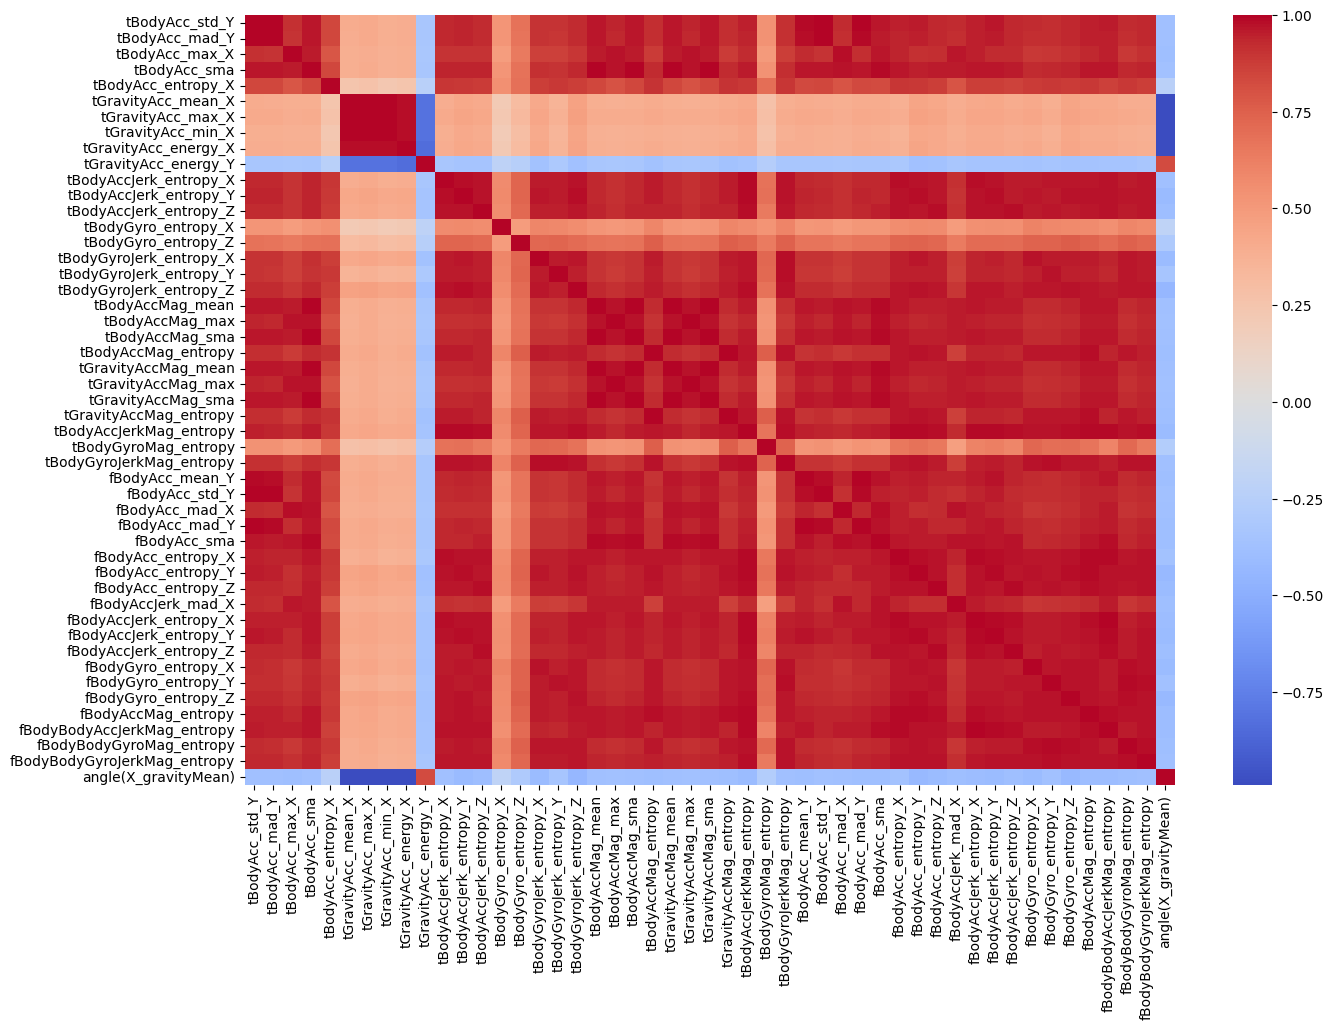

In [32]:
#Heatmap of the correlation of the full dataset
plt.figure(figsize=(15, 10))
sns.heatmap(df_final.corr(), annot=False, cmap='coolwarm')

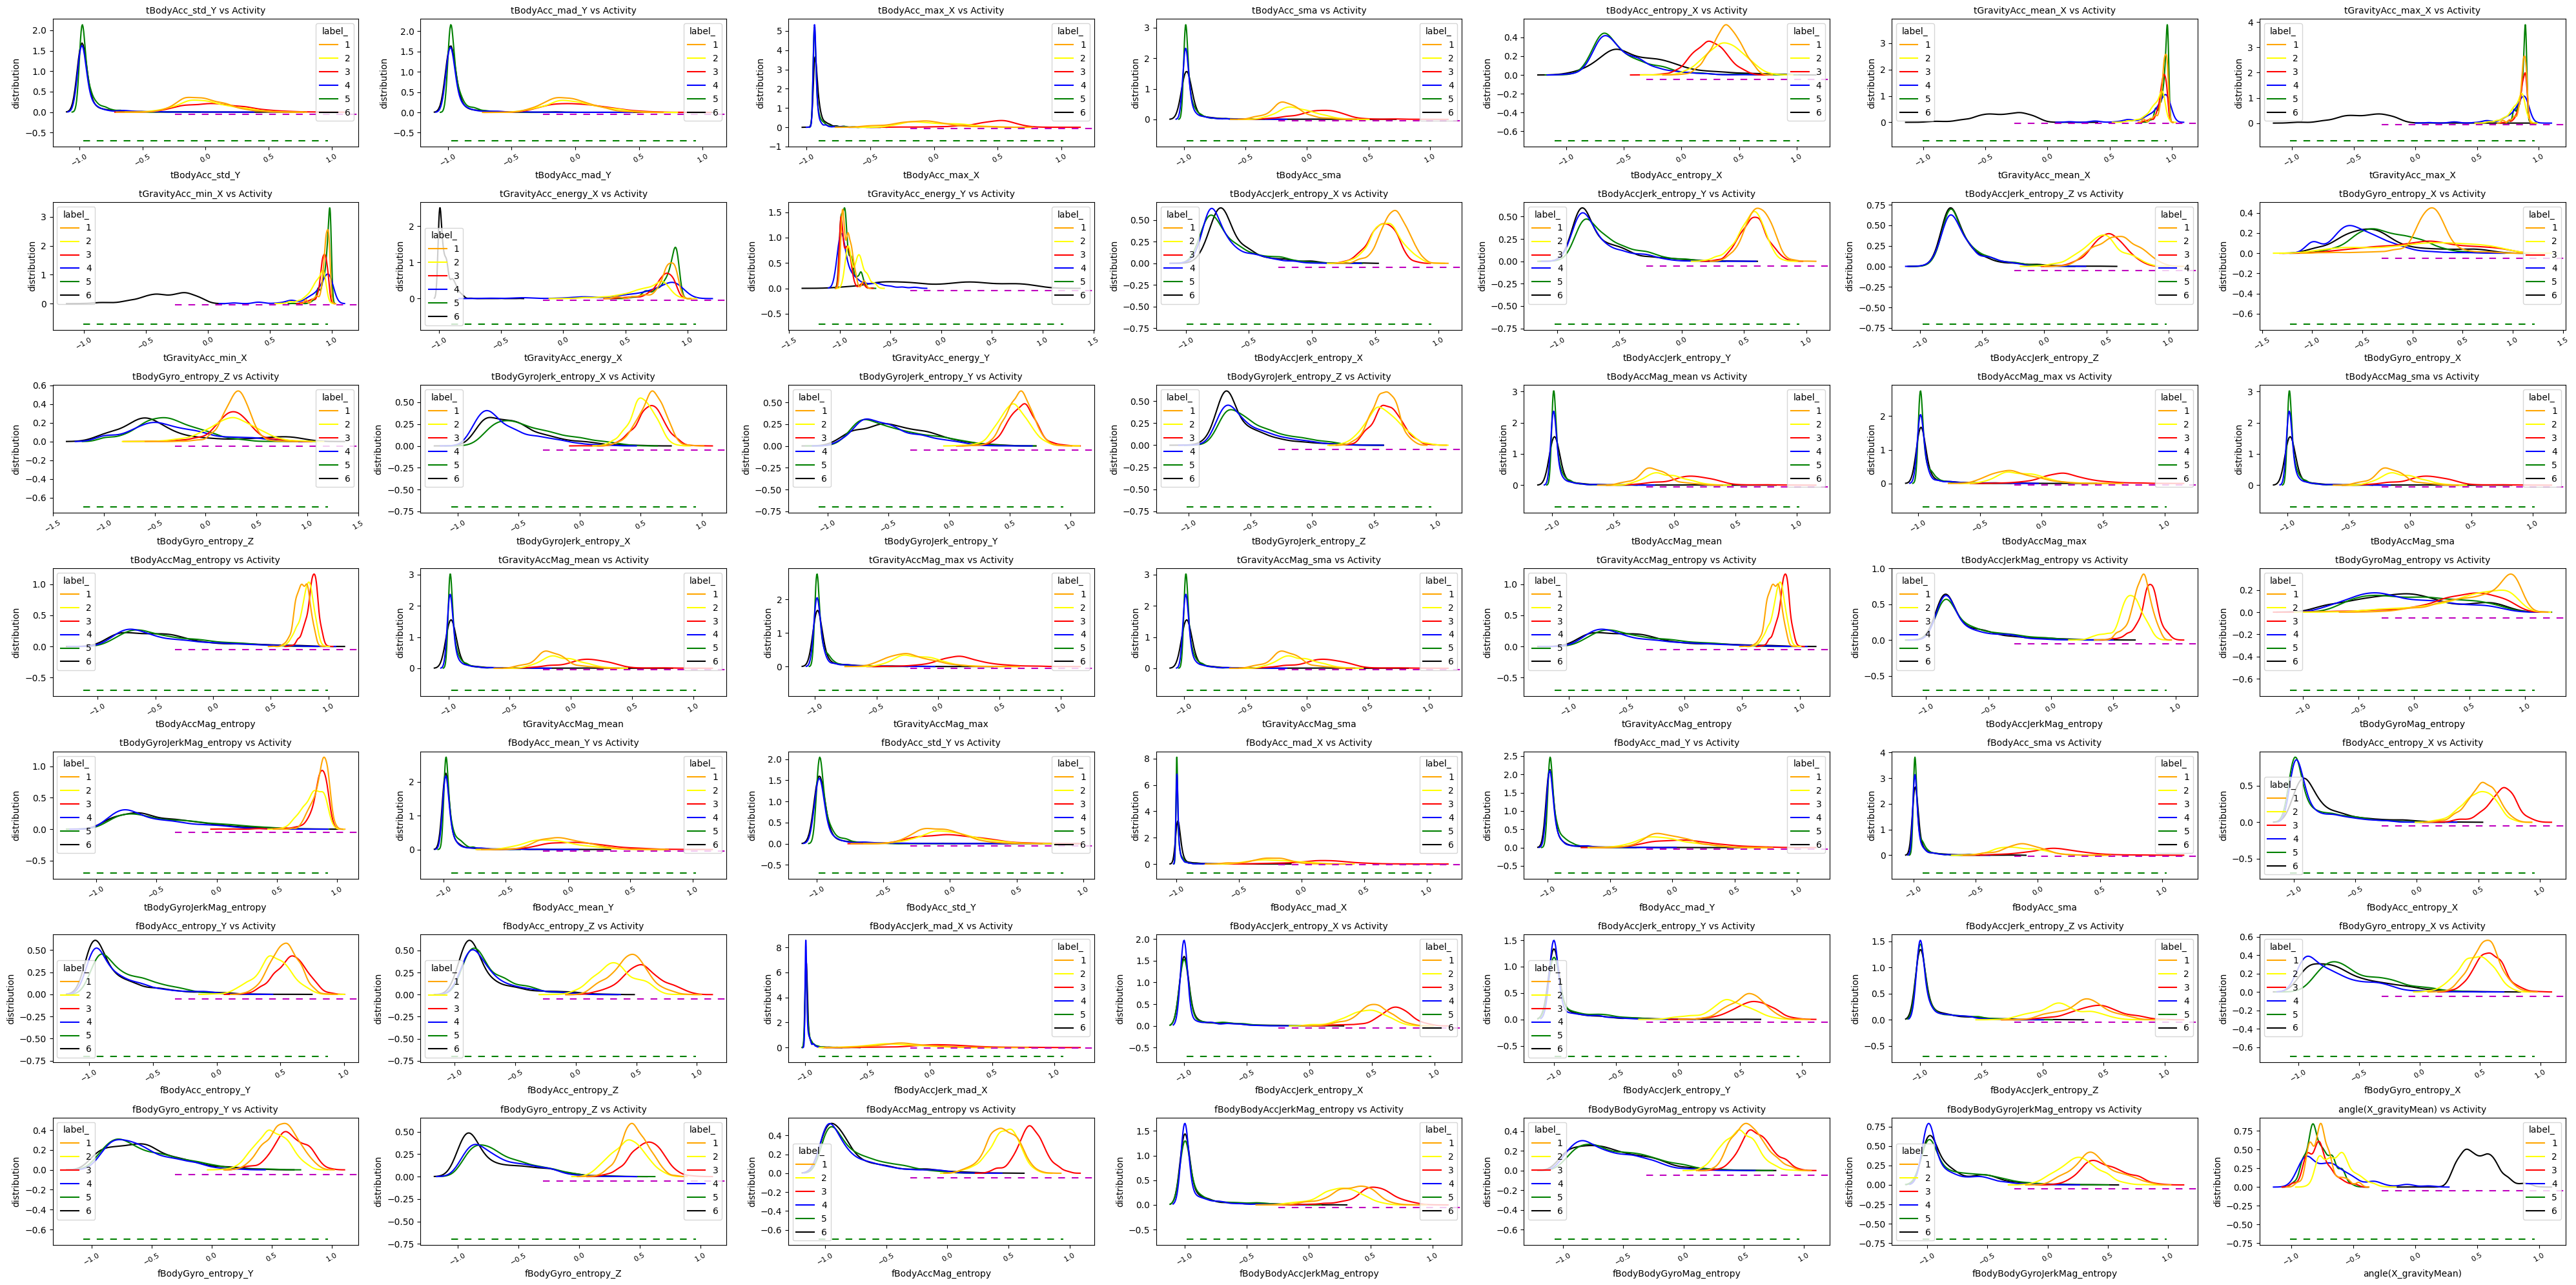

In [33]:
df_final_features = list(df_final.columns)
n_rows = 7
n_cols = 7
custom_colors = {1: 'orange', 2: 'yellow', 3: 'red', 4: 'blue', 5:'green', 6:'black'}
plt.figure(figsize=(40,20))
for i,col in enumerate(df_final_features,1):
  plt.subplot(n_rows, n_cols, i)
  sns.kdeplot(data=train_data, x=col, hue=full_data_y['label_'], palette=custom_colors)
  plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
  plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
  plt.title(f"{col} vs Activity", fontsize = 10)
  plt.xlabel(f"{col}", size=10)
  plt.ylabel('distribution', size=10)
  plt.xticks(rotation=30, fontsize=8)
  plt.tight_layout()
plt.show()

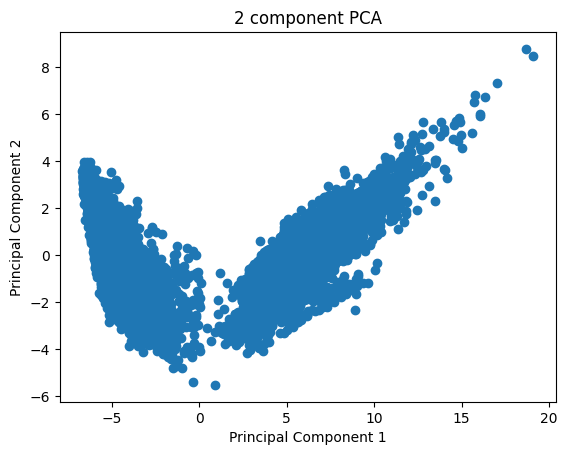

In [34]:
# PCA for dimensionality reduction visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(full_data)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
plt.figure()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA')
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.show()

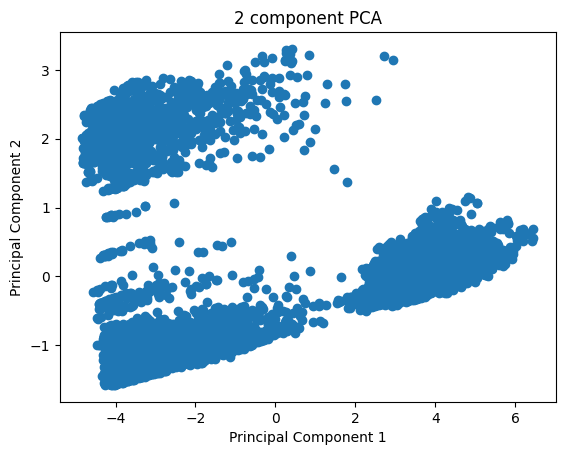

In [35]:
# PCA for dimensionality reduction visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_final)

principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
plt.figure()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA')
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.show()

## **Clustering with no Dimensionality Reduction**

The first part of the experiment involves using both algorithms to cluster the raw dataset with the selected features.

In [36]:
#
evaluation_metrics ={}

### K-Means

To select K the elbow method was applied and the silhouette socre was calculated for each value of k. The results of the elbow method were compared to the silhouette score for each cluster.

In [37]:
K_means_no_ca_metrics ={}
wcss = []
silhouette_scores = []
start = time()
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', n_init ='auto', max_iter=1000, random_state=42)
  kmeans.fit(df_final)
  wcss.append(kmeans.inertia_)
  if i ==1:
    score = None
  else:
    score = silhouette_score(df_final, kmeans.labels_)
  silhouette_scores.append(score)
end = time()
duration = end - start
K_means_no_ca_metrics['hyperparameter tuning duration'] = duration

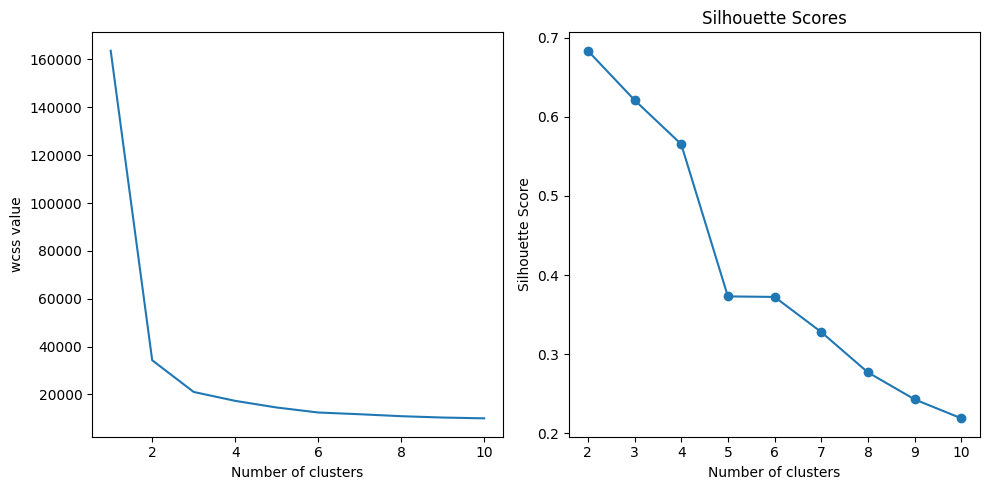

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(range(1,11),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('wcss value')

# Plotting the silhouette scores on the second subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [39]:
kmeans = KMeans(n_clusters=2, n_init='auto',init='k-means++', max_iter=1000,random_state=42)
# kmeans.fit(full_data)

In [40]:
start = time()
y_kmeans = kmeans.fit_predict(df_final)
end = time()



In [41]:
K_means_no_ca_metrics['training duration'] = end - start
score = silhouette_score(df_final, kmeans.labels_)
K_means_no_ca_metrics['silhouette score'] = score

evaluation_metrics['KMeans_no_ca'] = K_means_no_ca_metrics

In [42]:
pca = PCA(n_components=3)  # Use 2 for 2D visualization, 3 for 3D
principal_components = pca.fit_transform(df_final)

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3'])
df_pca['k_means_cluster'] = y_kmeans

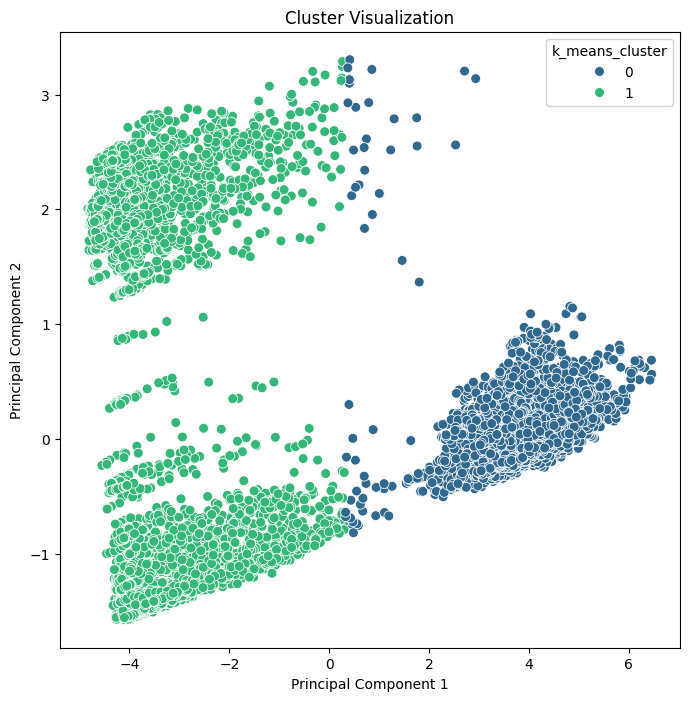

In [43]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='k_means_cluster', palette='viridis', s=50)
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

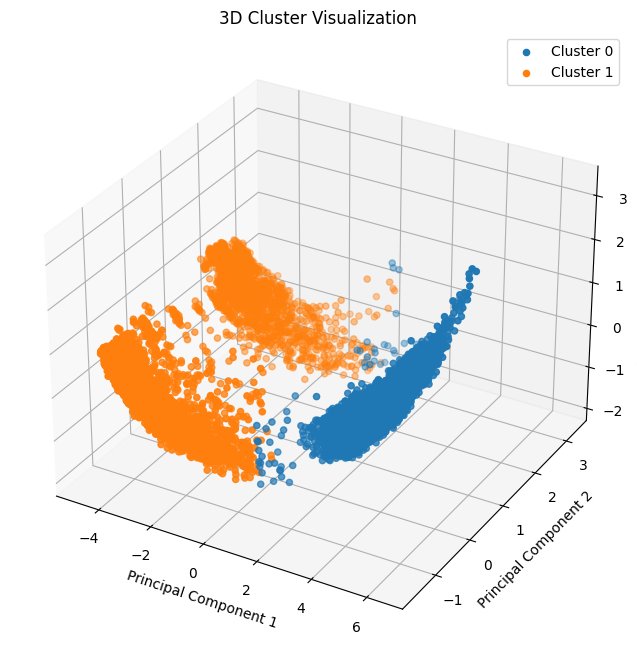

In [44]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster in different color
for cluster in set(df_pca['k_means_cluster']):
    cluster_data = df_pca[df_pca['k_means_cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}')

ax.set_title('3D Cluster Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

### DB Scan

Then the elbow method and silhouette scores were used to select the best value for ε and min_samples.

The selection of both hyperparameters were done in two steps. The first step involves finding the best ε values from integers between 1 and 20, 1 inclusive. This was done by training the model for different values of ε and setting the min_sample at a fixed value of 5.  The second step involved choosing the best value for min_samples parameter. This was done in similar way as the epsilon.


In [45]:
scaler = StandardScaler()
X = scaler.fit_transform(df_final)

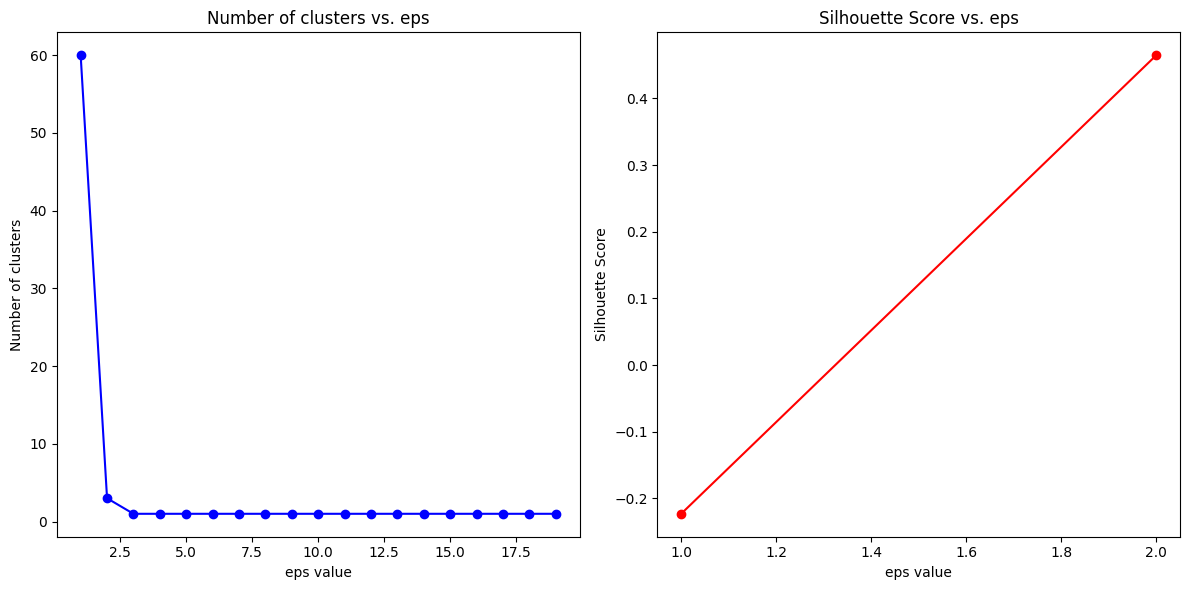

In [46]:
clusters = []
silhouette_scores = []
dbsacn_no_ca_metrics ={}

# Define the range for eps as a list of floats
eps_values = [float(i) for i in range(1, 20)]

# Iterate over different values of eps
start = time()
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    db_labels = dbscan.fit_predict(X)

    # Count the number of unique labels (excluding noise which is labeled as -1)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    clusters.append(n_clusters)

    # Calculate silhouette score only if there are at least two clusters (excluding noise)
    if n_clusters > 1:
        score = silhouette_score(X, db_labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(None)
end = time()
dbsacn_no_ca_metrics['hyperparameter tuning duration'] = end - start
# Plot the number of clusters and silhouette scores
plt.figure(figsize=(12, 6))

# Subplot for the number of clusters
plt.subplot(1, 2, 1)
plt.plot(eps_values, clusters, 'o-', color='blue')
plt.title('Number of clusters vs. eps')
plt.xlabel('eps value')
plt.ylabel('Number of clusters')

# Subplot for silhouette scores
plt.subplot(1, 2, 2)
plt.plot(eps_values, silhouette_scores, 'o-', color='red')
plt.title('Silhouette Score vs. eps')
plt.xlabel('eps value')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



In [47]:
clusters =[]
eps = [2.0,2.5,3.0]
min_samples_values = range(2, 10)

best_score = -1
best_params = {'eps': None, 'min_samples': None}
start = time()
for i in eps:
  for min_samples in min_samples_values:
        model = DBSCAN(eps=i, min_samples=min_samples)
        labels = model.fit_predict(X)

        # Calculate the silhouette score only if there is more than one cluster and less than len(X)-1 noise points
        if len(set(labels)) > 1 and np.sum(labels != -1) > 1:
            score = silhouette_score(X, labels)

            # Update the best parameters if the new score is better
            if score > best_score:
                best_score = score
                best_params['eps'] = i
                best_params['min_samples'] = min_samples
end= time()
print(f"Best score: {best_score}")
print(f"Best params: {best_params}")

dbsacn_no_ca_metrics['hyperparameter tuning duration'] = dbsacn_no_ca_metrics['hyperparameter tuning duration'] + (end - start)

Best score: 0.5183914947439348
Best params: {'eps': 2.0, 'min_samples': 8}


In [48]:
dbscan = DBSCAN(eps=2, min_samples=8)
start = time()
db_labels = dbscan.fit_predict(X)
end= time()
unique_labels = set(db_labels)
unique_labels

{-1, 0, 1}

In [49]:
full_sub_data['dbscan_with_no_pca'] = db_labels

In [50]:
score = silhouette_score(X, dbscan.labels_)
dbsacn_no_ca_metrics['training duration'] = end - start

dbsacn_no_ca_metrics['silhouette score'] = score

evaluation_metrics['DBSCAN_no_ca'] = dbsacn_no_ca_metrics

In [51]:
df_pca['dbscan_cluster'] = db_labels

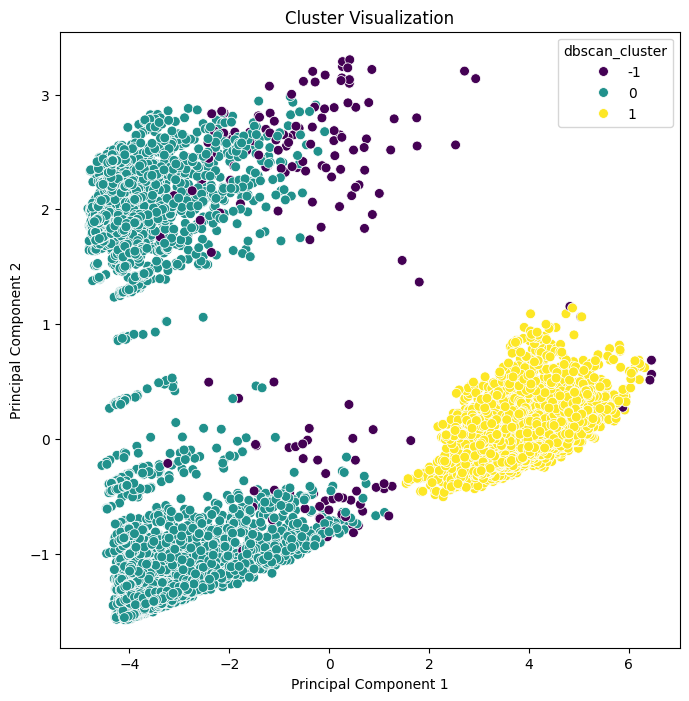

In [52]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='dbscan_cluster', palette='viridis', s=50)
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

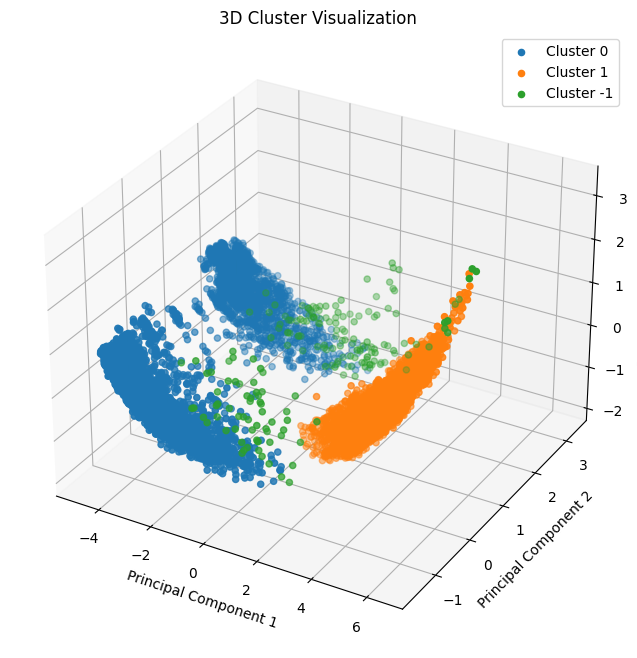

In [53]:
# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster in different color
for cluster in set(df_pca['dbscan_cluster']):
    cluster_data = df_pca[df_pca['dbscan_cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}')

ax.set_title('3D Cluster Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

## **Clustering with Dimensionality Reduction**

This section describes the training of the models after component analysis was applied to the full dataset.
The Principal Component Analysis (PCA) technique was used to reduce the dimensions of the dataset. PCA identifies the meaningful basis to represent a given dataset with the expectation that this new representation filters out noise and reveals hidden information in the dataset. PCA is useful for dimensionality reduction and data visualization

 To select the best values for n_compunents, the explained variance was calculated, and the cumulative sum of the variance was used to determine the elbow point. The elbow point is the point where the change in variance starts to reduce, hence a flattening of the cumulative variance.



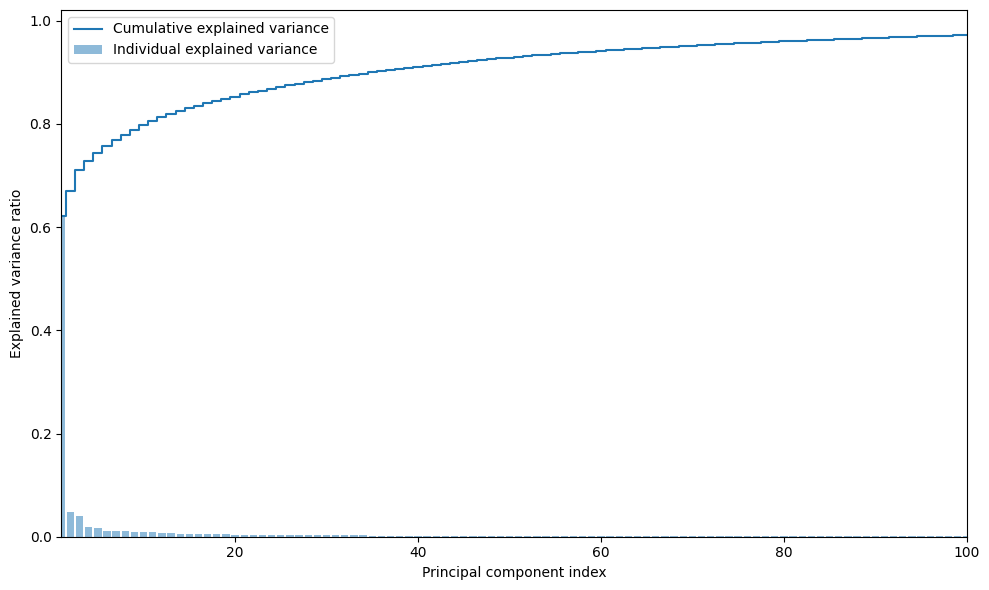

Optimal number of PCA components based on elbow method: 3


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Compute PCA without reducing dimensionality to get full variance explanation
pca = PCA()
pca.fit(full_data)
explained_variance = pca.explained_variance_ratio_

# Limit the number of components for the scree plot to the first 100
n_components_to_display = 100
explained_variance_limited = explained_variance[:n_components_to_display]

# Generate Scree plot for the first 100 components
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_limited) + 1), explained_variance_limited, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance_limited) + 1), np.cumsum(explained_variance_limited), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.xlim(1, n_components_to_display)  # Set the x-axis limits to show only the first 100 components
plt.tight_layout()
plt.show()

# Determine the elbow point, which is where the variance starts to level off
# This is subjective but typically you look for a 'knee' in the scree plot
# One method is to look for the point where the second derivative (the change in the change of variance explained) is greatest
second_derivative = np.diff(np.cumsum(explained_variance), 2)
elbow_point = np.argmin(second_derivative) + 2  # +2 because the second derivative reduces the length by 2
print(f"Optimal number of PCA components based on elbow method: {elbow_point}")


In [55]:
pca_cols = [f'PC{i}' for i in range(1,4)]


In [56]:
pca = PCA(n_components=3)  # Use 2 for 2D visualization, 3 for 3D
principal_components = pca.fit_transform(full_data)

# Create a DataFrame with the principal components
df_pca_2 = pd.DataFrame(data=principal_components, columns=pca_cols)

### KMeans with PCA

In [57]:
k_means_with_ca_metrics ={}
wcss = []
silhouette_scores = []
start = time()
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', n_init ='auto', max_iter=1000, random_state=42)
  kmeans.fit(df_pca_2)
  wcss.append(kmeans.inertia_)
  if i > 1:
        score = silhouette_score(df_pca_2, kmeans.labels_)

  else:
       score = None
  silhouette_scores.append(score)

end = time()
duration = end - start
k_means_with_ca_metrics['hyperparameter tuning duration'] = duration

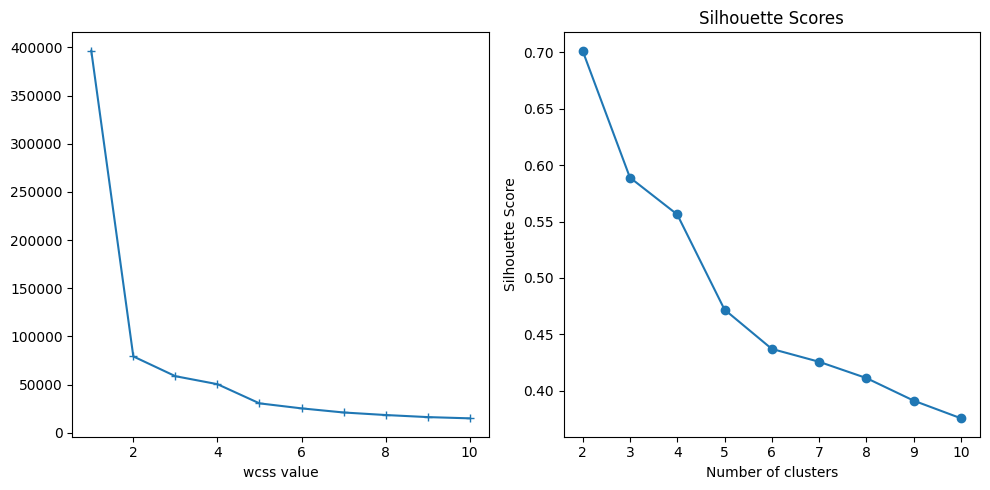

In [58]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(range(1,11),wcss, marker='+')
plt.xlabel('No of clusters')
plt.xlabel('wcss value')

# Plotting the silhouette scores on the second subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [59]:
kmeans = KMeans(n_clusters=2, n_init='auto',init='k-means++', max_iter=1000,random_state=42)
# kmeans.fit(full_data)

In [60]:
start= time()
df_pca_2['kmeans_cluster'] = kmeans.fit_predict(df_pca_2)
end = time()

In [61]:
k_means_with_ca_metrics['training duration'] = end - start
score = silhouette_score(df_final, kmeans.labels_)
k_means_with_ca_metrics['silhouette score'] = score

evaluation_metrics['KMeans_with_pca'] = k_means_with_ca_metrics

In [62]:
df_pca_2.columns

Index(['PC1', 'PC2', 'PC3', 'kmeans_cluster'], dtype='object')

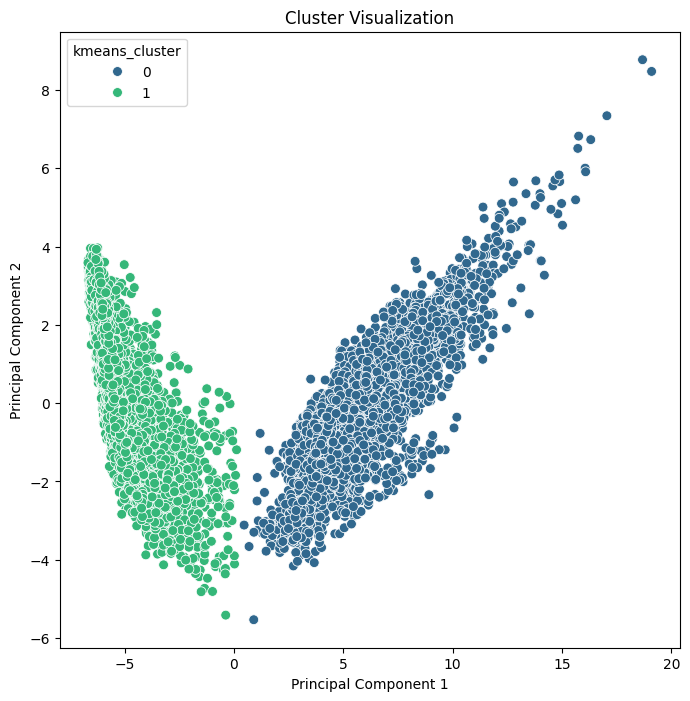

In [63]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='PC1', y='PC2', data=df_pca_2, hue='kmeans_cluster', palette='viridis', s=50)
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

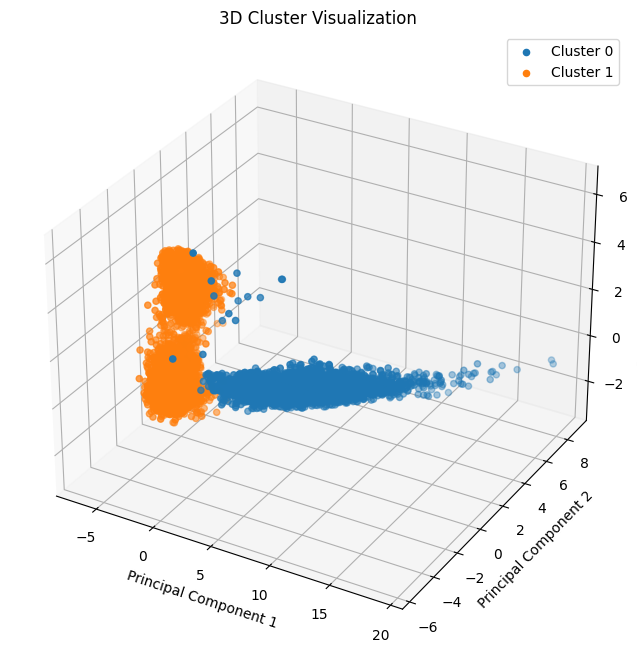

In [64]:
# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster in different color
for cluster in set(df_pca_2['kmeans_cluster']):
    cluster_data = df_pca_2[df_pca_2['kmeans_cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}')

ax.set_title('3D Cluster Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

### DBSCAN with PCA data

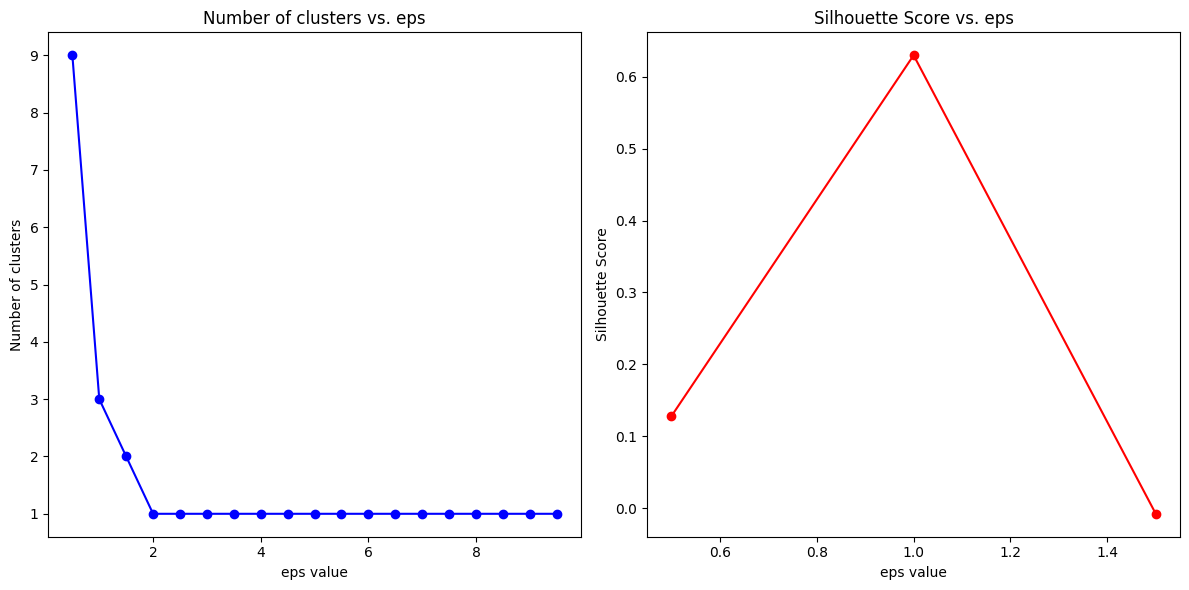

In [65]:

clusters = []
silhouette_scores = []
dbsacn_with_pca_metrics = {}
# Define the range for eps as a list of floats
eps_values = [float(i) for i in np.arange(0.5, 10.0,0.5)]

# Iterate over different values of eps
start = time()
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=4)
    db_labels = dbscan.fit_predict(df_pca_2)

    # Count the number of unique labels (excluding noise which is labeled as -1)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    clusters.append(n_clusters)

    # Calculate silhouette score only if there are at least two clusters (excluding noise)
    if n_clusters > 1:
        score = silhouette_score(df_pca_2, db_labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(None)
end = time()
dbsacn_with_pca_metrics['hyperparameter tuning duration'] = end - start
# Plot the number of clusters and silhouette scores
plt.figure(figsize=(12, 6))

# Subplot for the number of clusters
plt.subplot(1, 2, 1)
plt.plot(eps_values, clusters, 'o-', color='blue')
plt.title('Number of clusters vs. eps')
plt.xlabel('eps value')
plt.ylabel('Number of clusters')

# Subplot for silhouette scores
plt.subplot(1, 2, 2)
plt.plot(eps_values, silhouette_scores, 'o-', color='red')
plt.title('Silhouette Score vs. eps')
plt.xlabel('eps value')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



In [66]:
clusters =[]
eps = [1.0,1.5]
min_samples_values = range(2, 10)

best_score = -1
best_params = {'eps': None, 'min_samples': None}
start = time()
for i in eps:
  for min_samples in min_samples_values:
        model = DBSCAN(eps=i, min_samples=min_samples)
        labels = model.fit_predict(df_pca_2)

        # Calculate the silhouette score only if there is more than one cluster and less than len(X)-1 noise points
        if len(set(labels)) > 1 and np.sum(labels != -1) > 1:
            score = silhouette_score(df_pca_2, labels)

            # Update the best parameters if the new score is better
            if score > best_score:
                best_score = score
                best_params['eps'] = i
                best_params['min_samples'] = min_samples
end = time()
dbsacn_with_pca_metrics['hyperparameter tuning duration'] = dbsacn_with_pca_metrics['hyperparameter tuning duration'] + (end - start)
print(f"Best score: {best_score}")
print(f"Best params: {best_params}")



Best score: 0.6671974825902401
Best params: {'eps': 1.0, 'min_samples': 7}


In [67]:
dbscan = DBSCAN(eps=1, min_samples=7)
start = time()
db_labels = dbscan.fit_predict(df_pca_2)
end = time()
unique_labels = set(db_labels)
unique_labels

{-1, 0, 1}

In [68]:
full_sub_data['dbscan_with_pca'] = db_labels

In [69]:
score = silhouette_score(df_pca_2, dbscan.labels_)
dbsacn_with_pca_metrics['training duration'] = end - start

dbsacn_with_pca_metrics['silhouette score'] = score

evaluation_metrics['DBSCAN_with_pca'] = dbsacn_with_pca_metrics

In [70]:
df_pca_2['dbscan_cluster'] = db_labels

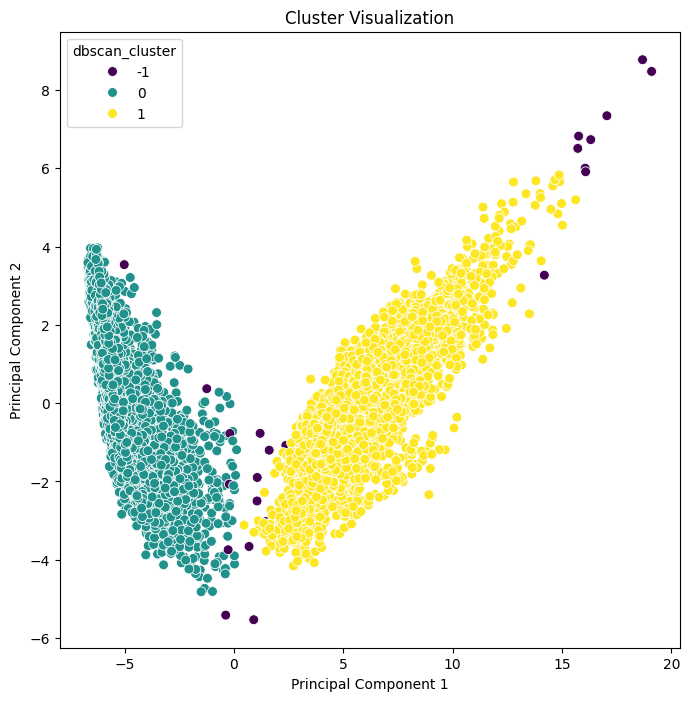

In [71]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='PC1', y='PC2', data=df_pca_2, hue='dbscan_cluster', palette='viridis', s=50)
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

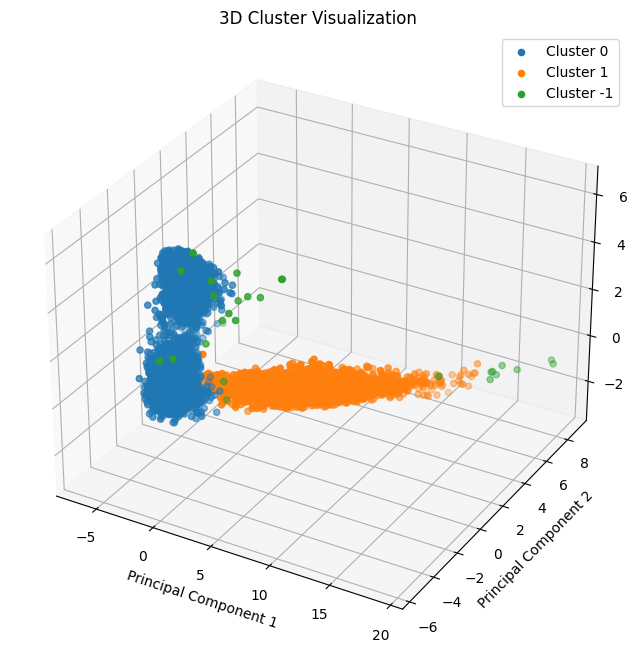

In [72]:
# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster in different color
for cluster in set(df_pca_2['dbscan_cluster']):
    cluster_data = df_pca_2[df_pca_2['dbscan_cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}')

ax.set_title('3D Cluster Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

## Evaluation of Models

In [73]:
evaluation_metrics_df = pd.DataFrame(evaluation_metrics)

In [74]:
evaluation_metrics_df

KMeans_no_ca  DBSCAN_no_ca  KMeans_with_pca  \
hyperparameter tuning duration     20.207438    175.001695        17.425730   
training duration                   0.137138      2.219227         0.020520   
silhouette score                    0.683390      0.518391         0.682639   

                                DBSCAN_with_pca  
hyperparameter tuning duration        73.591681  
training duration                      0.388397  
silhouette score                       0.667197

### investigating features that make up PCA

In [75]:
components = pca.components_
components_df = pd.DataFrame(components, columns=full_data.columns, index=[f'PC{i+1}' for i in range(components.shape[0])])

components_df

tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
PC1        -0.000011        -0.000294        -0.000260        0.072485   
PC2         0.002703        -0.000425        -0.000948        0.019619   
PC3        -0.003477        -0.000500         0.000522        0.008924   

     tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
PC1        0.083685        0.064389        0.067979        0.080483   
PC2       -0.005593       -0.020474        0.020324       -0.010054   
PC3        0.012150        0.019798        0.008190        0.013710   

     tBodyAcc_mad_Z  tBodyAcc_max_X  ...  fBodyBodyGyroJerkMag_meanFreq  \
PC1        0.063358        0.088470  ...                      -0.005580   
PC2       -0.025474        0.022359  ...                       0.056937   
PC3        0.020979        0.004909  ...                      -0.014718   

     fBodyBodyGyroJerkMag_skewness  fBodyBodyGyroJerkMag_kurtosis  \
PC1                       0.013336                       0.010927   
PC2                      -0.016174                      -0.012337   
PC3                       0.010793                       0.006791   

     angle(tBodyAccMean_gravity)  angle(tBodyAccJerkMean)_gravityMean)  \
PC1                    -0.001270                             -0.001081   
PC2                    -0.009124                             -0.001920   
PC3                     0.002405                              0.005049   

     angle(tBodyGyroMean_gravityMean)  angle(tBodyGyroJerkMean_gravityMean)  \
PC1                          0.001857                             -0.001935   
PC2                          0.026817                             -0.012702   
PC3                         -0.008516                              0.012331   

     angle(X_gravityMean)  angle(Y_gravityMean)  angle(Z_gravityMean)  
PC1             -0.036965              0.027084              0.021325  
PC2              0.114005             -0.072106             -0.039929  
PC3              0.271338             -0.111327             -0.099773  

[3 rows x 561 columns]

In [76]:
top_contributors = {}
for i, pc in enumerate(components_df.index):
    # Getting the absolute values of loadings to consider contribution magnitude
    loadings = components_df.loc[pc].abs()
    # Sorting the features based on their contribution magnitude
    sorted_loadings = loadings.sort_values(ascending=False)
    # Taking the top N features, e.g., top 3 contributors
    top_contributors[pc] = sorted_loadings[:5].index.tolist()

# Displaying the top contributing features for each principal component


In [77]:
set_contributors = set()
for pc in list(top_contributors.keys()):
  print(f"Top contributor for {pc} are: {top_contributors[pc]}\n")
  set_contributors.update(top_contributors[pc])

print (f"\nThere are {len(set_contributors)} unique \n \nContributors are: {set_contributors}")

Top contributor for PC1 are: ['fBodyAccJerk_entropy_X', 'fBodyAccJerk_entropy_Y', 'tBodyAccJerkMag_entropy', 'fBodyAcc_entropy_X', 'fBodyAccMag_entropy']

Top contributor for PC2 are: ['tGravityAcc_energy_X', 'tBodyGyroMag_entropy', 'fBodyAcc_skewness_Z', 'fBodyAcc_kurtosis_Z', 'tBodyGyroMag_arCoeff1']

Top contributor for PC3 are: ['tGravityAcc_energy_X', 'angle(X_gravityMean)', 'tGravityAcc_mean_X', 'tGravityAcc_min_X', 'tGravityAcc_max_X']


There are 14 unique 
 
Contributors are: {'tBodyGyroMag_entropy', 'tBodyAccJerkMag_entropy', 'tBodyGyroMag_arCoeff1', 'fBodyAccJerk_entropy_X', 'tGravityAcc_max_X', 'fBodyAccJerk_entropy_Y', 'tGravityAcc_energy_X', 'fBodyAcc_skewness_Z', 'angle(X_gravityMean)', 'fBodyAcc_entropy_X', 'fBodyAcc_kurtosis_Z', 'tGravityAcc_mean_X', 'fBodyAccMag_entropy', 'tGravityAcc_min_X'}


In [78]:
#compare unique features with selected features

similar_features = set(df_final_features).intersection(set_contributors)

print (f"\nThere are {len(similar_features)} similar contributors.\n\nSimilar Contributors are: {similar_features}")


There are 11 similar contributors.

Similar Contributors are: {'tBodyGyroMag_entropy', 'tBodyAccJerkMag_entropy', 'fBodyAccJerk_entropy_X', 'fBodyAccJerk_entropy_Y', 'tGravityAcc_energy_X', 'angle(X_gravityMean)', 'fBodyAcc_entropy_X', 'tGravityAcc_mean_X', 'tGravityAcc_max_X', 'fBodyAccMag_entropy', 'tGravityAcc_min_X'}


In [79]:
#Features in df final that are not part of the top 15 features for each pca

difference_features = set(df_final_features).difference(set_contributors)

print (f"\nThere are {len(difference_features)} different features.\n\ndifferent features are: {difference_features}")


There are 38 different features.

different features are: {'tBodyAccMag_mean', 'tGravityAccMag_sma', 'tBodyGyro_entropy_Z', 'fBodyGyro_entropy_Z', 'fBodyGyro_entropy_X', 'fBodyBodyGyroMag_entropy', 'tBodyAccMag_max', 'tGravityAccMag_max', 'fBodyAcc_entropy_Z', 'tBodyAccMag_entropy', 'tGravityAccMag_entropy', 'tBodyAccJerk_entropy_X', 'fBodyAccJerk_entropy_Z', 'tBodyGyro_entropy_X', 'tGravityAccMag_mean', 'tBodyAcc_mad_Y', 'tBodyAcc_sma', 'tBodyAccMag_sma', 'fBodyAcc_mean_Y', 'tBodyAccJerk_entropy_Y', 'tBodyAccJerk_entropy_Z', 'fBodyAcc_mad_Y', 'tBodyGyroJerk_entropy_X', 'tBodyAcc_std_Y', 'tBodyGyroJerk_entropy_Z', 'fBodyAcc_sma', 'tGravityAcc_energy_Y', 'fBodyAccJerk_mad_X', 'fBodyBodyAccJerkMag_entropy', 'fBodyBodyGyroJerkMag_entropy', 'fBodyAcc_std_Y', 'fBodyGyro_entropy_Y', 'tBodyGyroJerkMag_entropy', 'tBodyAcc_entropy_X', 'fBodyAcc_mad_X', 'tBodyGyroJerk_entropy_Y', 'fBodyAcc_entropy_Y', 'tBodyAcc_max_X'}


## **Clustering Visualization and  Analysis**

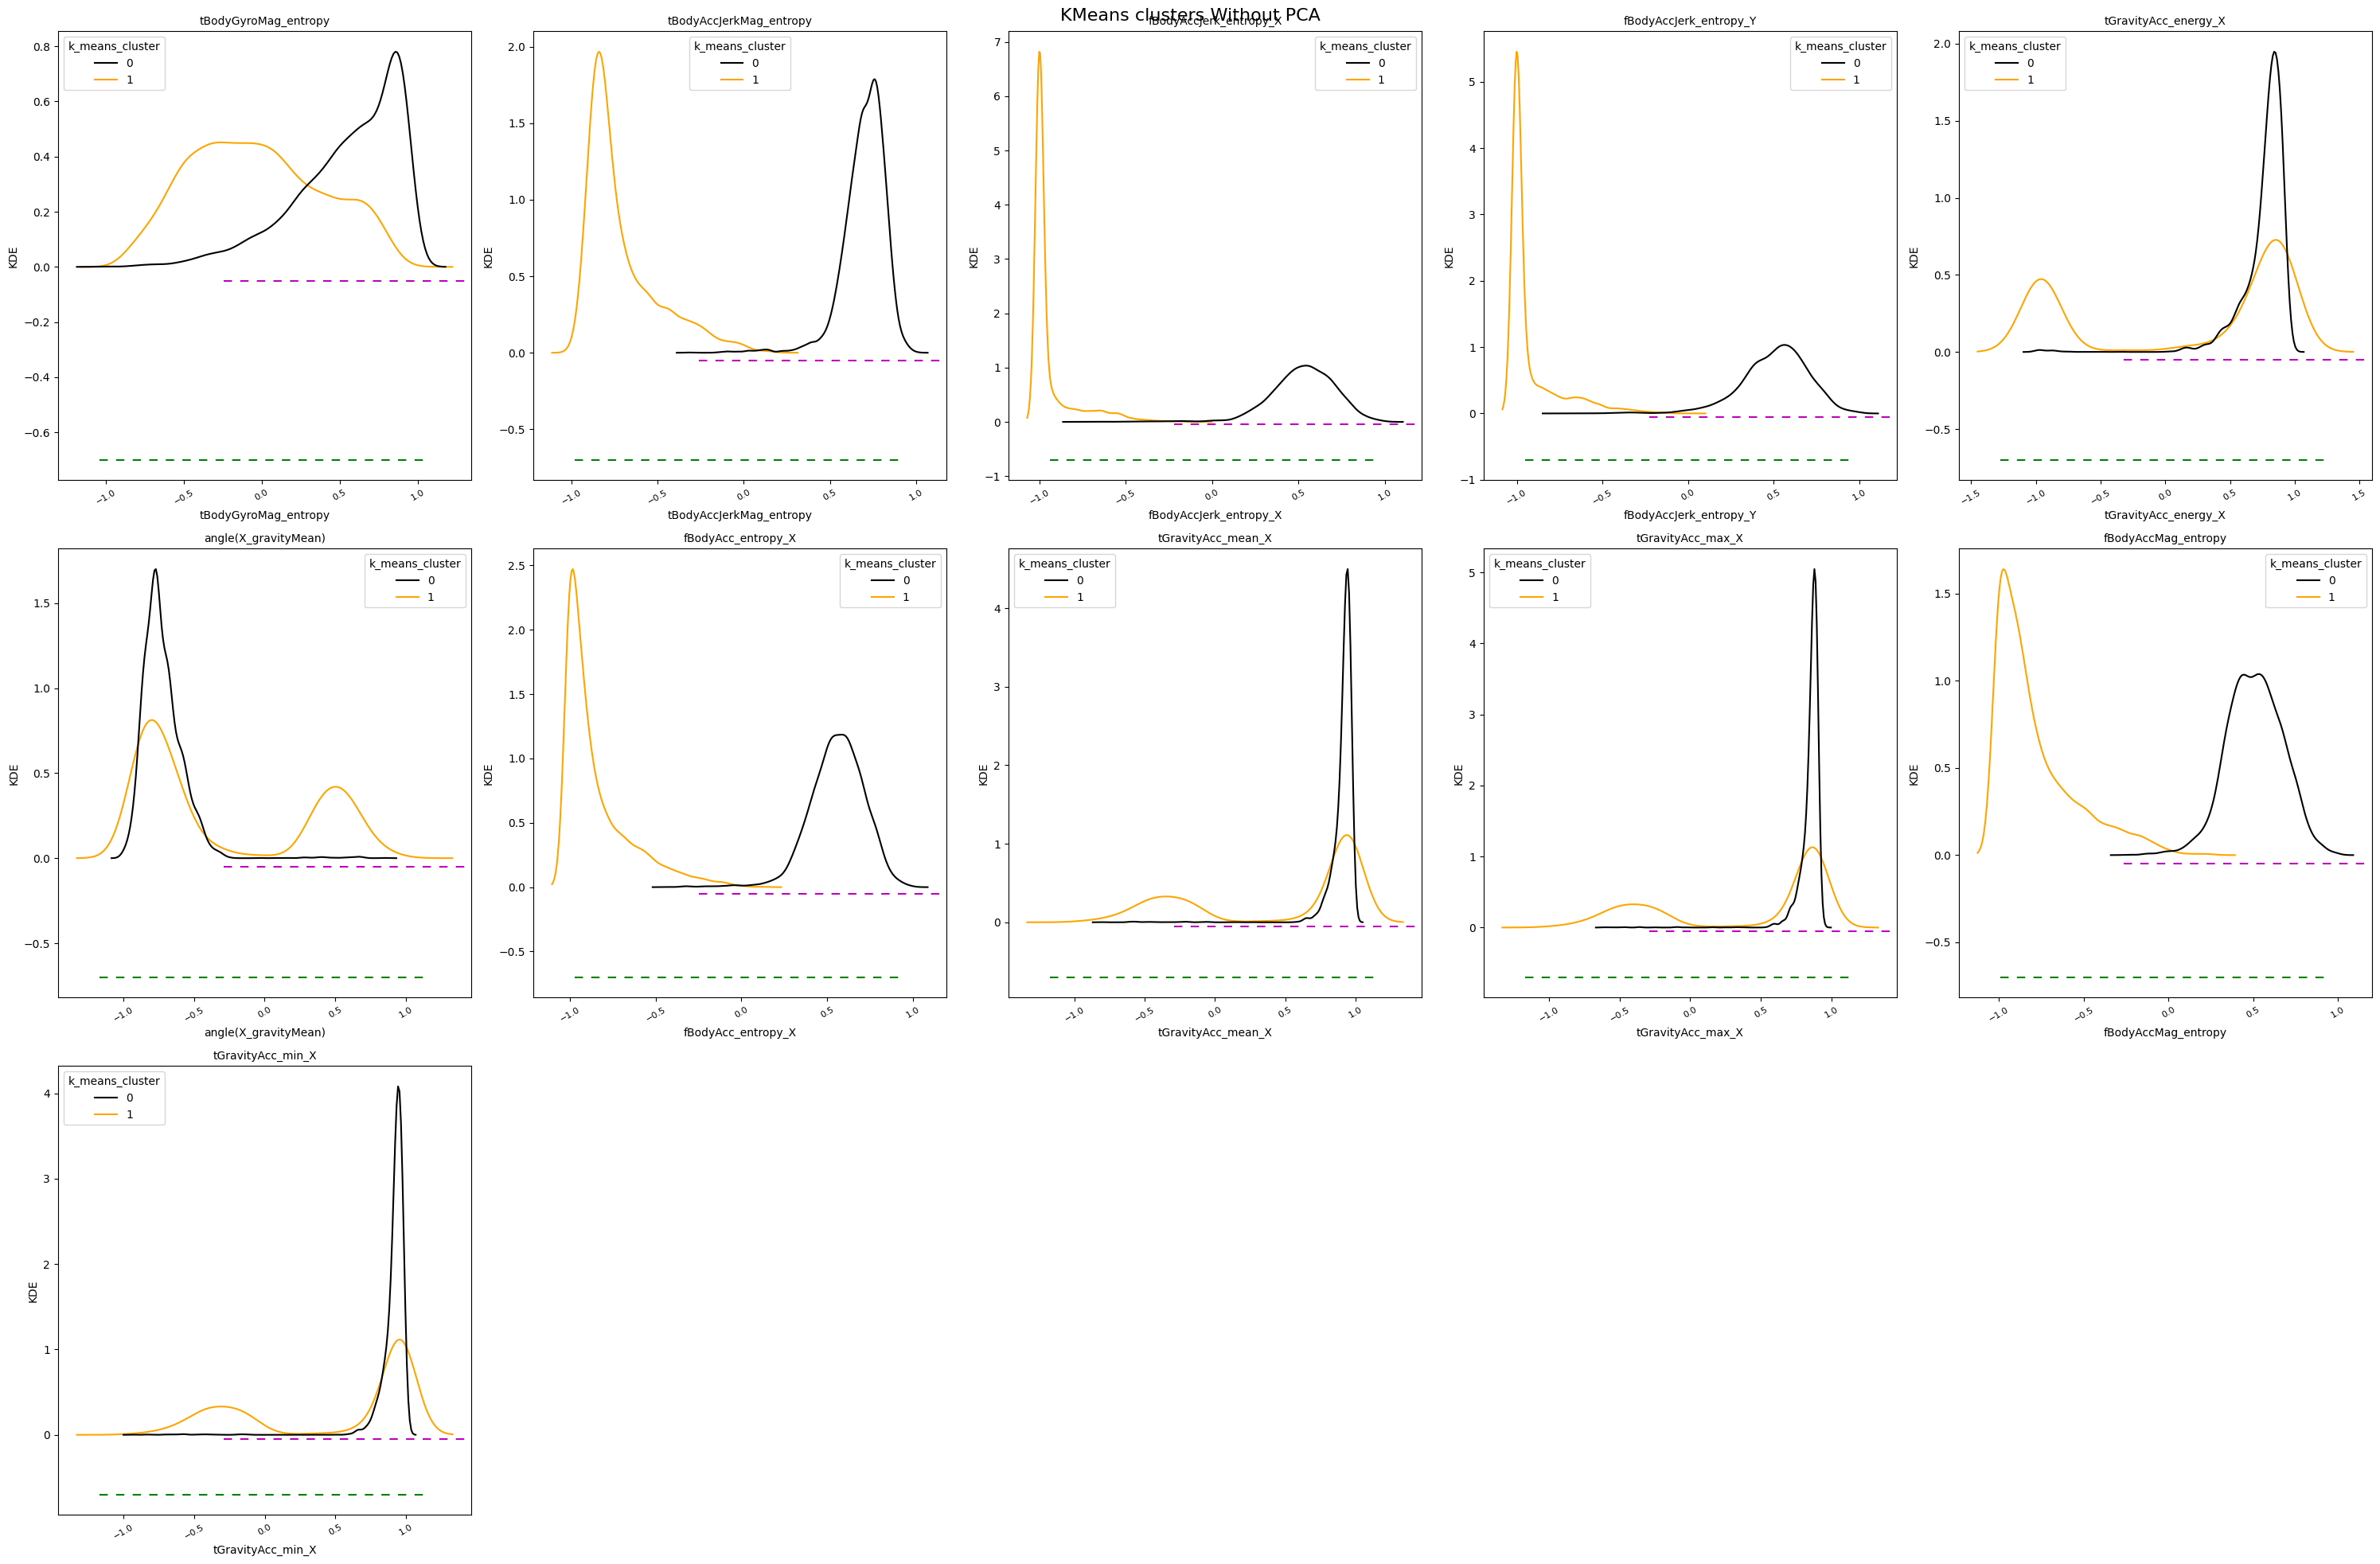

In [80]:
vis_features = list(similar_features)
n_rows = 3
n_cols = 5
custom_colors = {1: 'orange', 2: 'blue' }
plt.figure(figsize=(30,20))
plt.suptitle('KMeans clusters Without PCA', fontsize=16)
for i,col in enumerate(vis_features,1):
  plt.subplot(n_rows, n_cols, i)
  sns.kdeplot(data=df_final, x=col, hue=df_pca['k_means_cluster'], palette=custom_colors)
  plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
  plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
  plt.title(f"{col}", fontsize = 10)
  plt.xlabel(f'{col}', size=10)
  plt.ylabel('KDE', size=10)
  plt.xticks(rotation=30, fontsize=8)
  plt.tight_layout()

plt.show()

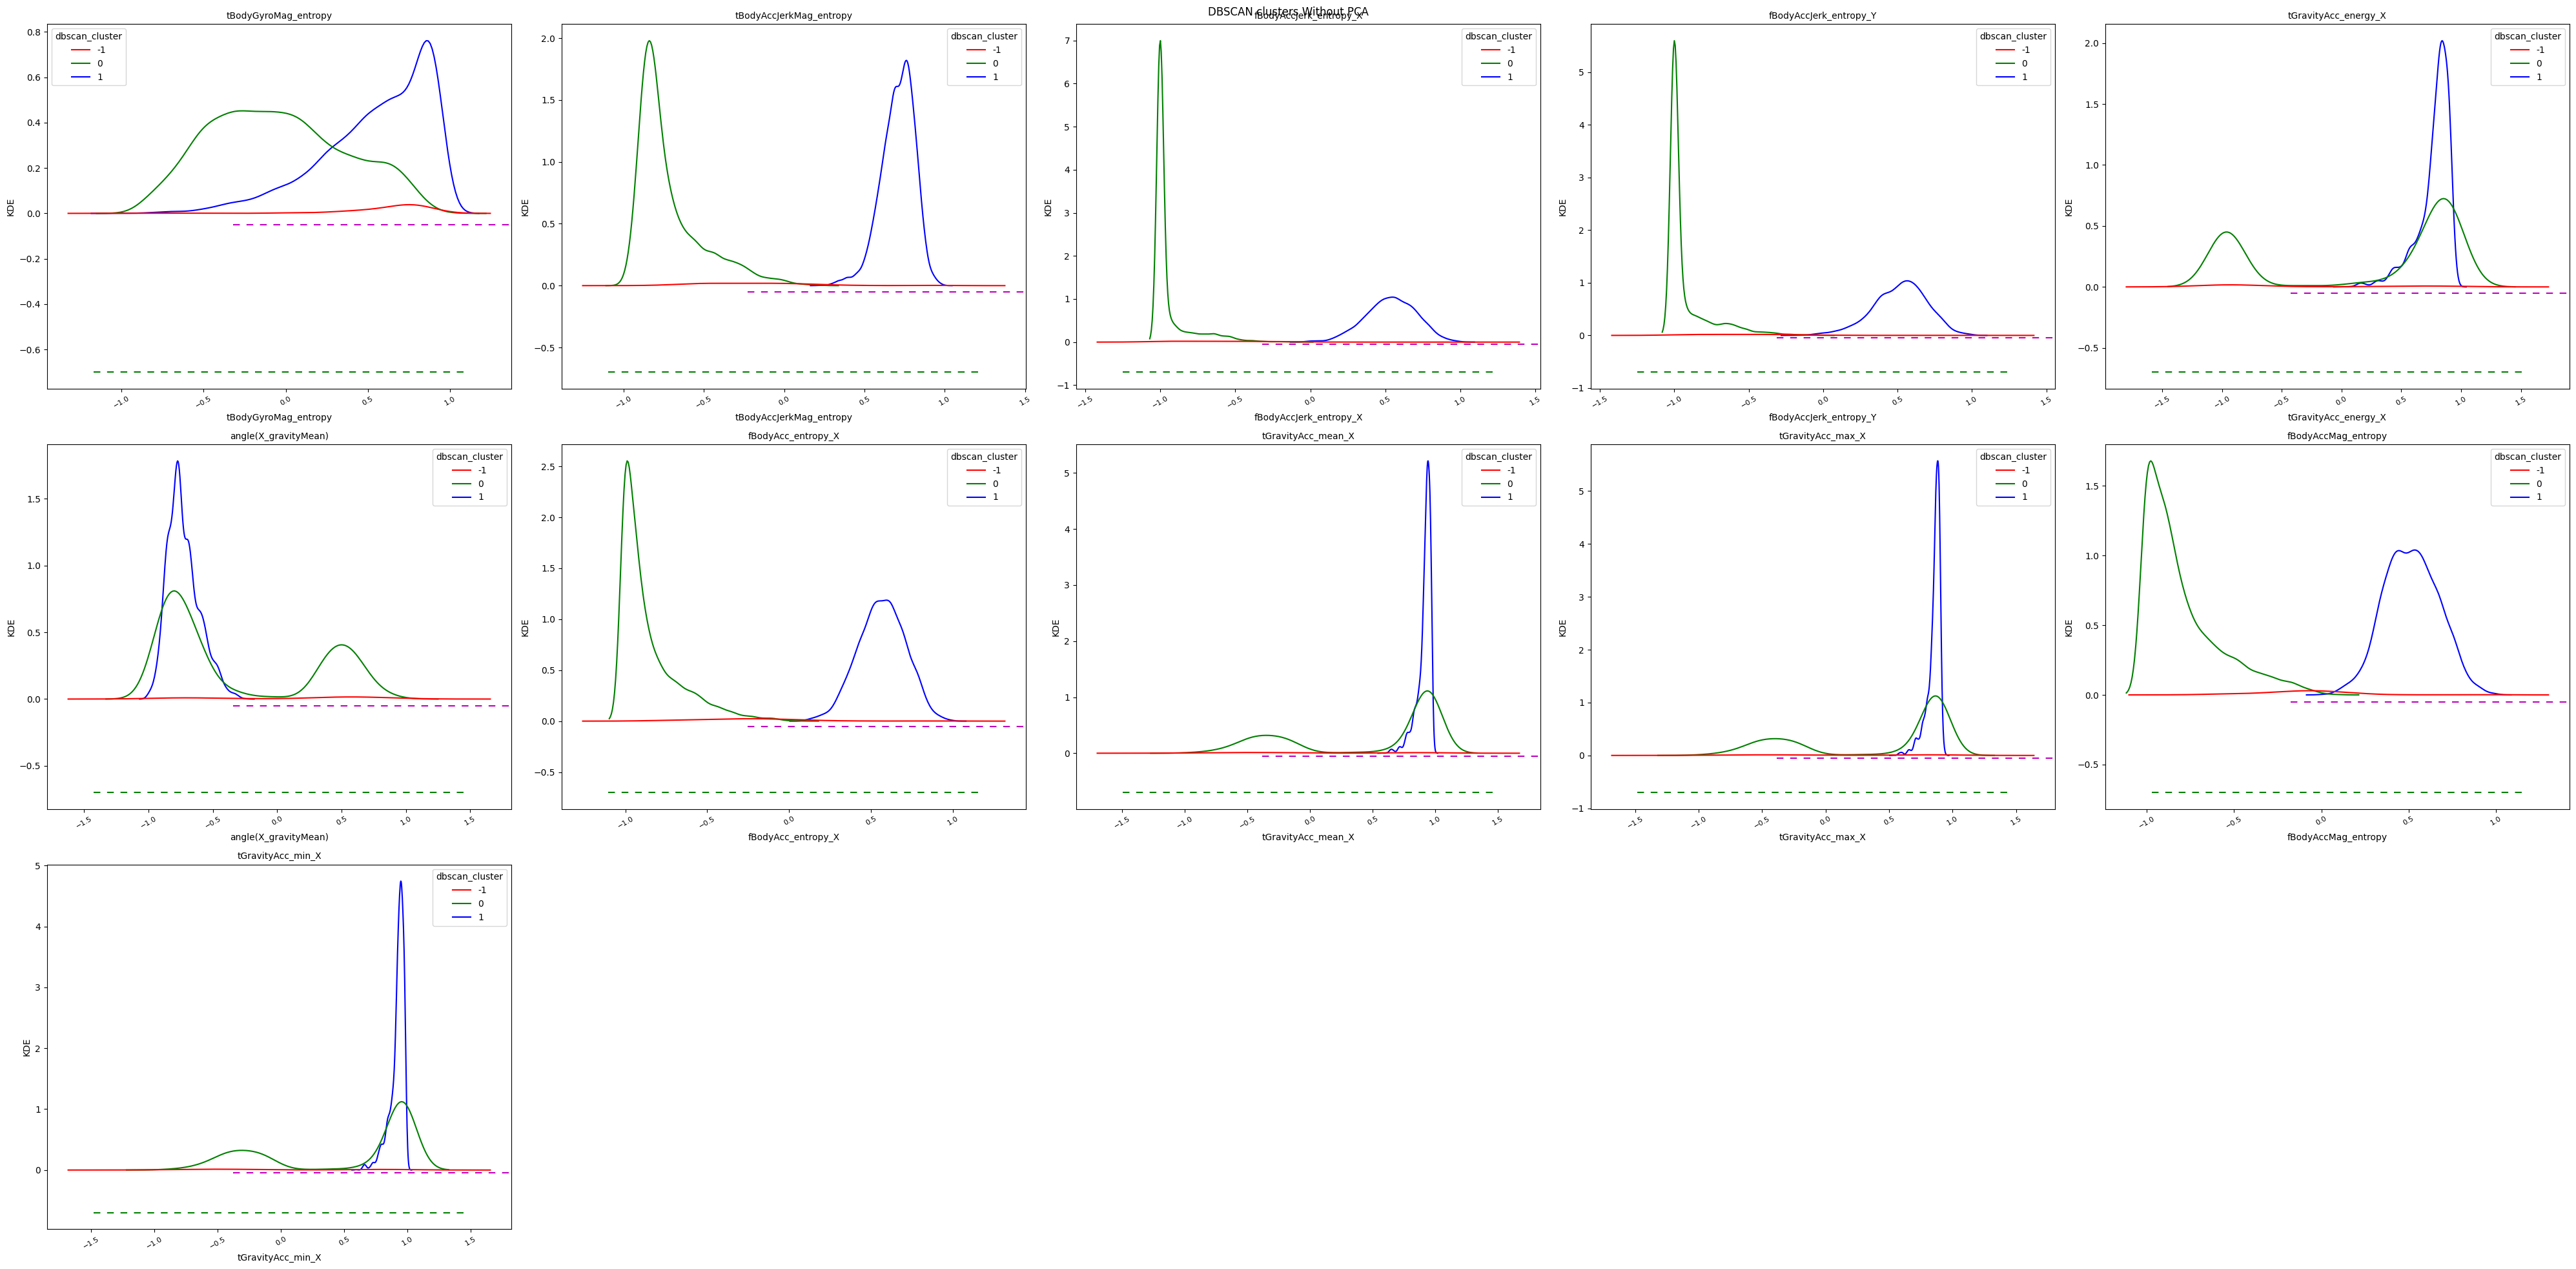

In [81]:
n_rows = 3
n_cols = 5
custom_colors = {0: 'green', 1: 'blue', -1:'red'}
plt.figure(figsize=(40,20))
plt.suptitle('DBSCAN clusters Without PCA', fontsize=12)
for i,col in enumerate(vis_features,1):
  plt.subplot(n_rows, n_cols, i)
  sns.kdeplot(data=df_final, x=col, hue=df_pca['dbscan_cluster'], palette=custom_colors)
  plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
  plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
  plt.title(f"{col}", fontsize = 10)
  plt.xlabel(f'{col}', size=10)
  plt.ylabel('KDE', size=10)
  plt.xticks(rotation=30, fontsize=8)
  plt.tight_layout()
plt.show()

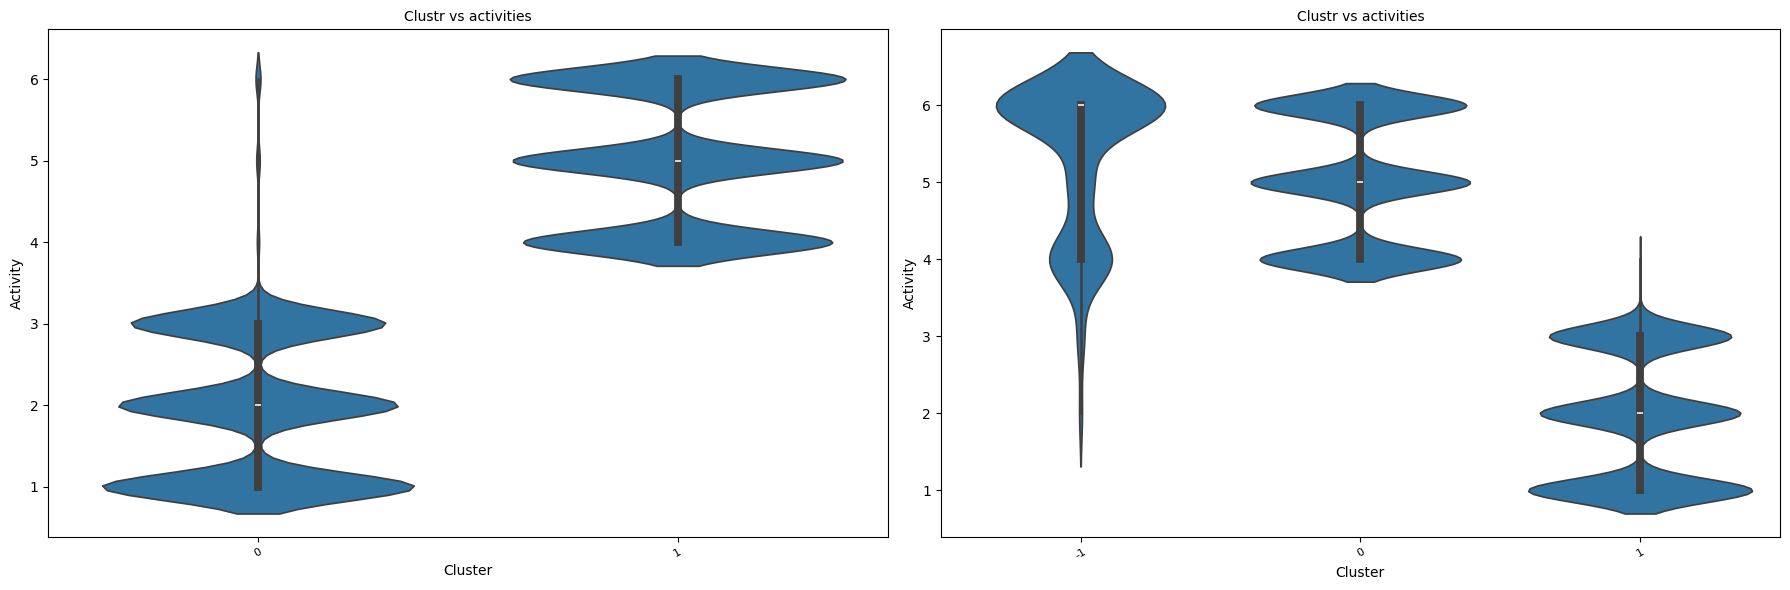

In [82]:
plt.figure(figsize=(18, 6))

# Subplot for the number of clusters
plt.subplot(1, 2, 1)
sns.violinplot(y=full_data_y['label_'], x=df_pca['k_means_cluster'])
plt.title(f"Clustr vs activities", fontsize = 10)
plt.xlabel("Cluster", size=10)
plt.ylabel(f'Activity', size=10)
plt.xticks(rotation=30, fontsize=8)


plt.subplot(1, 2, 2)
sns.violinplot(y=full_data_y['label_'], x=df_pca['dbscan_cluster'])

plt.title(f"Clustr vs activities", fontsize = 10)
plt.xlabel("Cluster", size=10)
plt.ylabel(f'Activity', size=10)
plt.xticks(rotation=30, fontsize=8)
plt.tight_layout()

plt.show()

In [83]:
vis_features

['tBodyGyroMag_entropy',
 'tBodyAccJerkMag_entropy',
 'fBodyAccJerk_entropy_X',
 'fBodyAccJerk_entropy_Y',
 'tGravityAcc_energy_X',
 'angle(X_gravityMean)',
 'fBodyAcc_entropy_X',
 'tGravityAcc_mean_X',
 'tGravityAcc_max_X',
 'fBodyAccMag_entropy',
 'tGravityAcc_min_X']

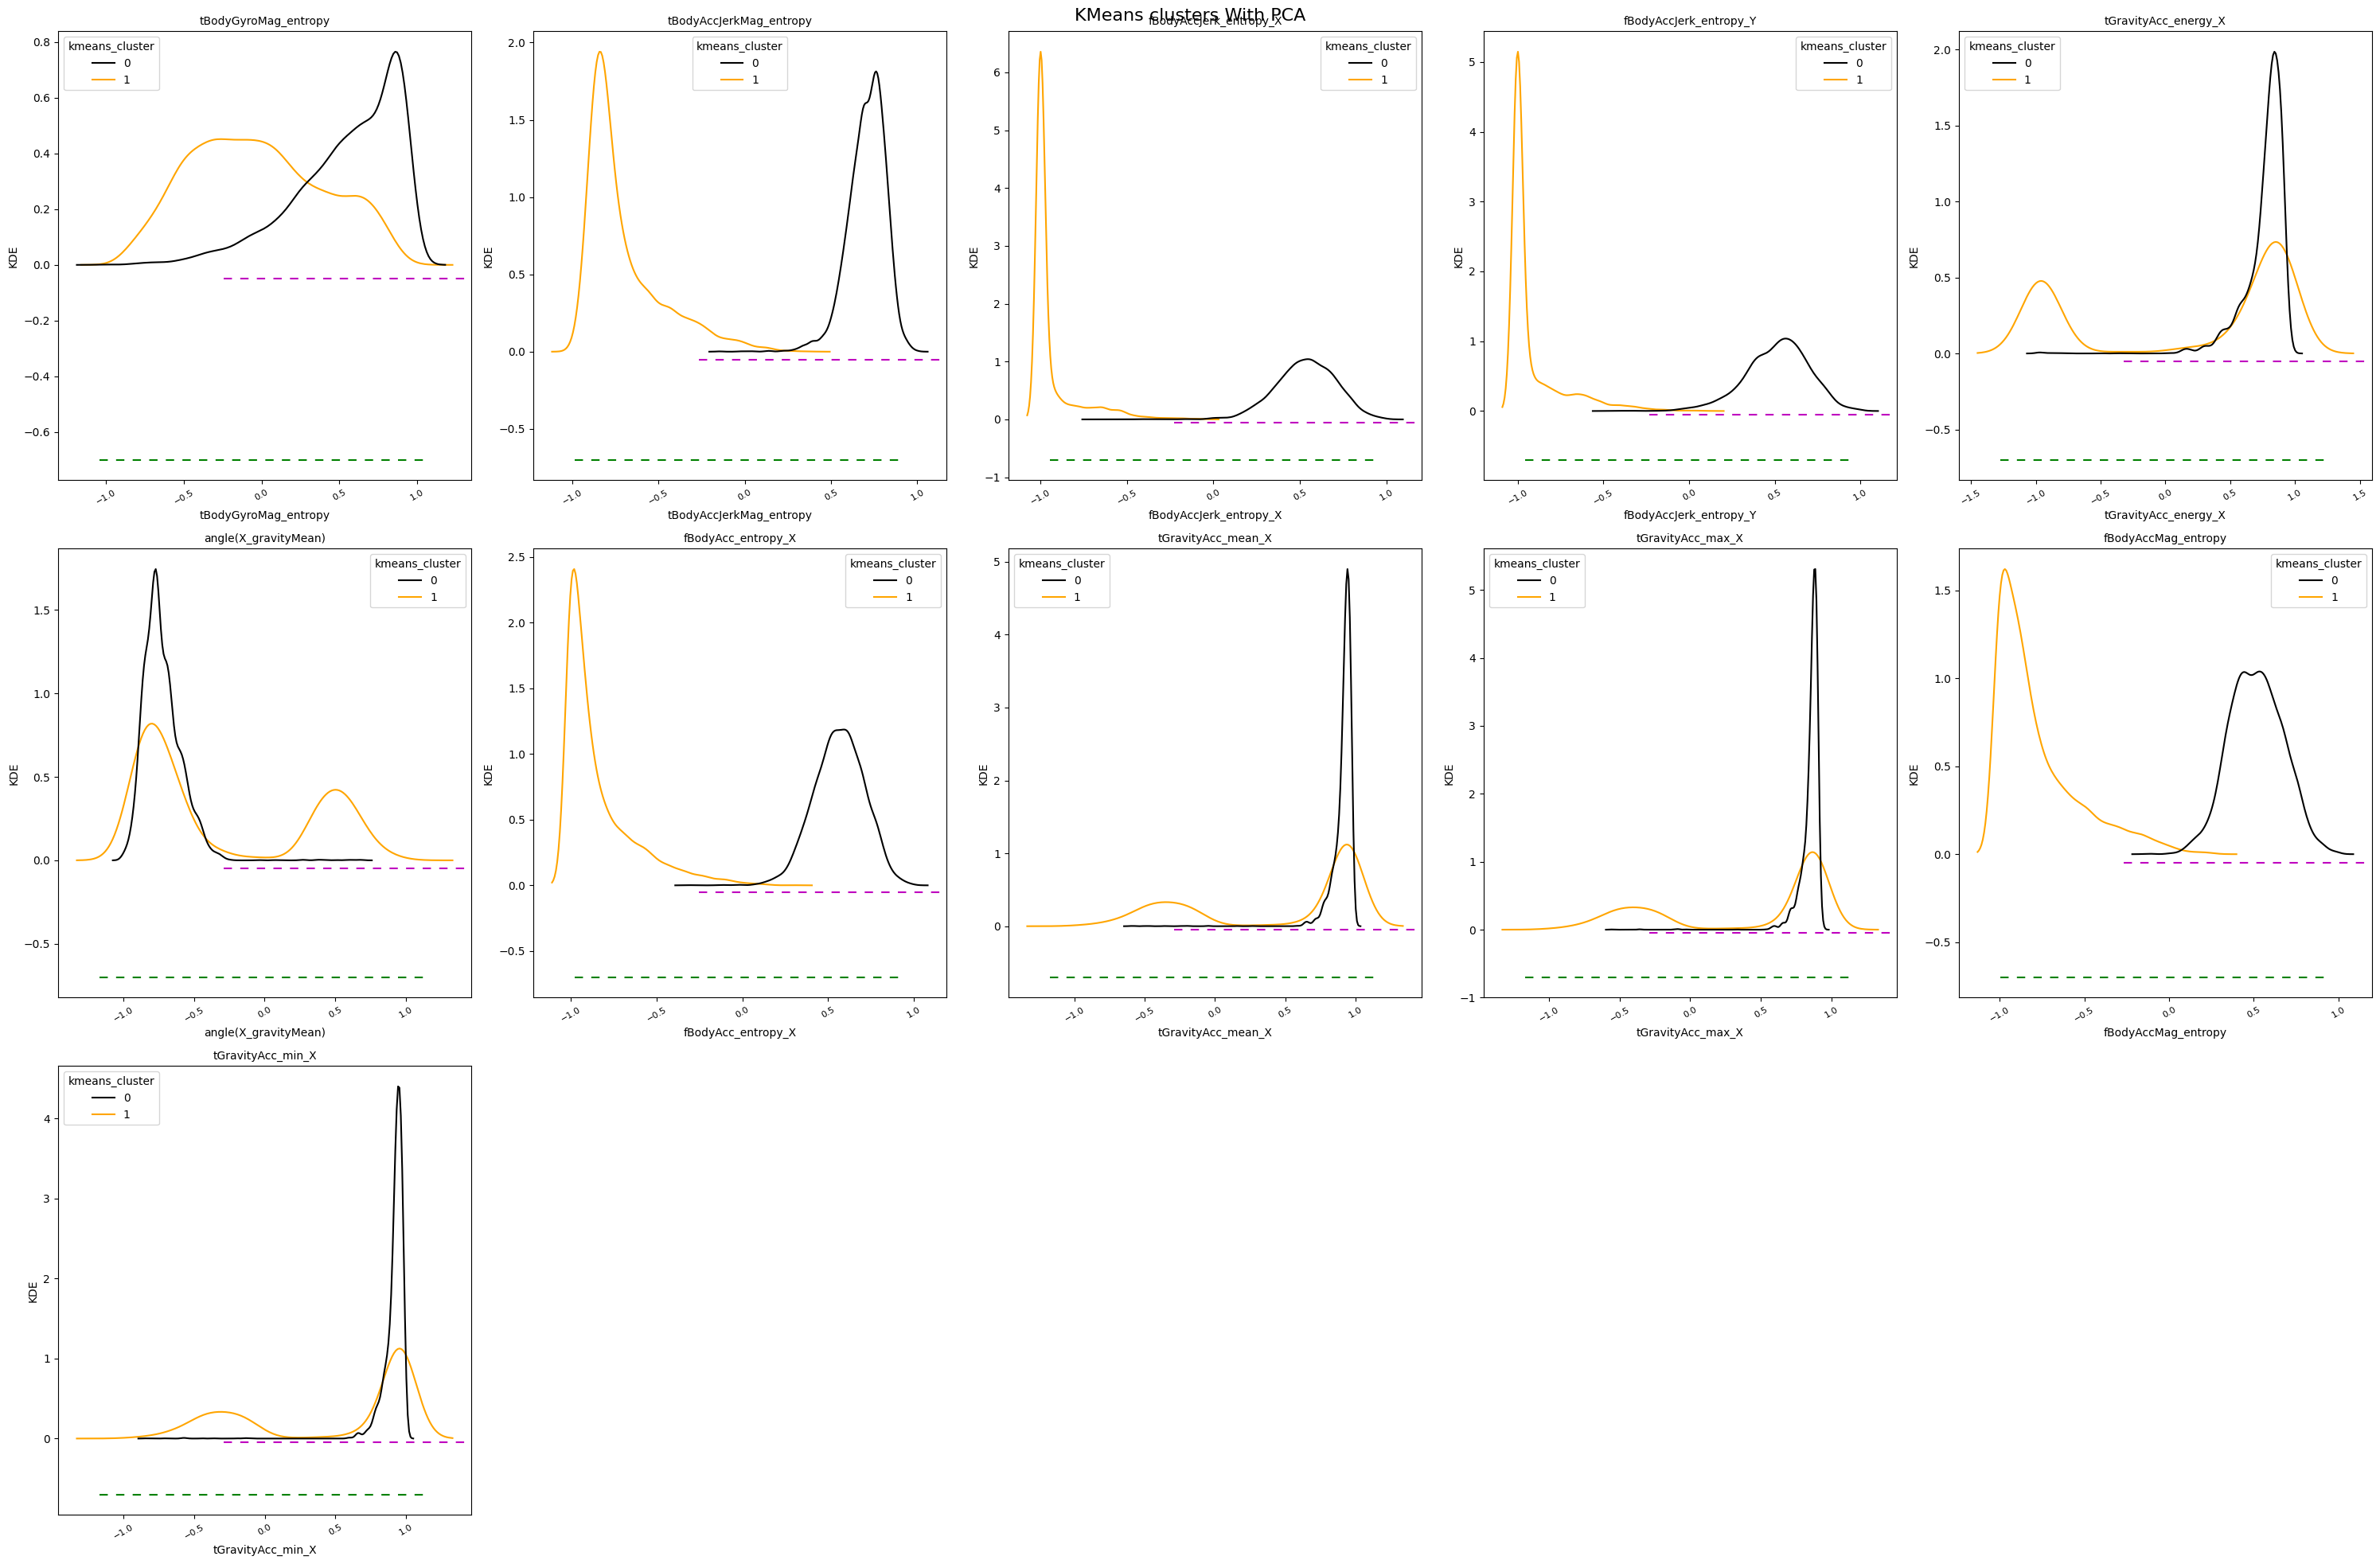

In [84]:
df_final_features = list(df_final.columns)
n_rows = 3
n_cols = 5
custom_colors = {1: 'orange', 2: 'blue' }

plt.figure(figsize=(30,20))
plt.suptitle('KMeans clusters With PCA', fontsize=16)
for i,col in enumerate(vis_features,1):
  plt.subplot(n_rows, n_cols, i)
  sns.kdeplot(data=df_final, x=col, hue=df_pca_2['kmeans_cluster'], palette=custom_colors)
  plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
  plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
  plt.title(f"{col}", fontsize = 10)
  plt.xlabel(f"{col}", size=10)
  plt.ylabel('KDE', size=10)
  plt.xticks(rotation=30, fontsize=8)
  plt.tight_layout()
plt.show()

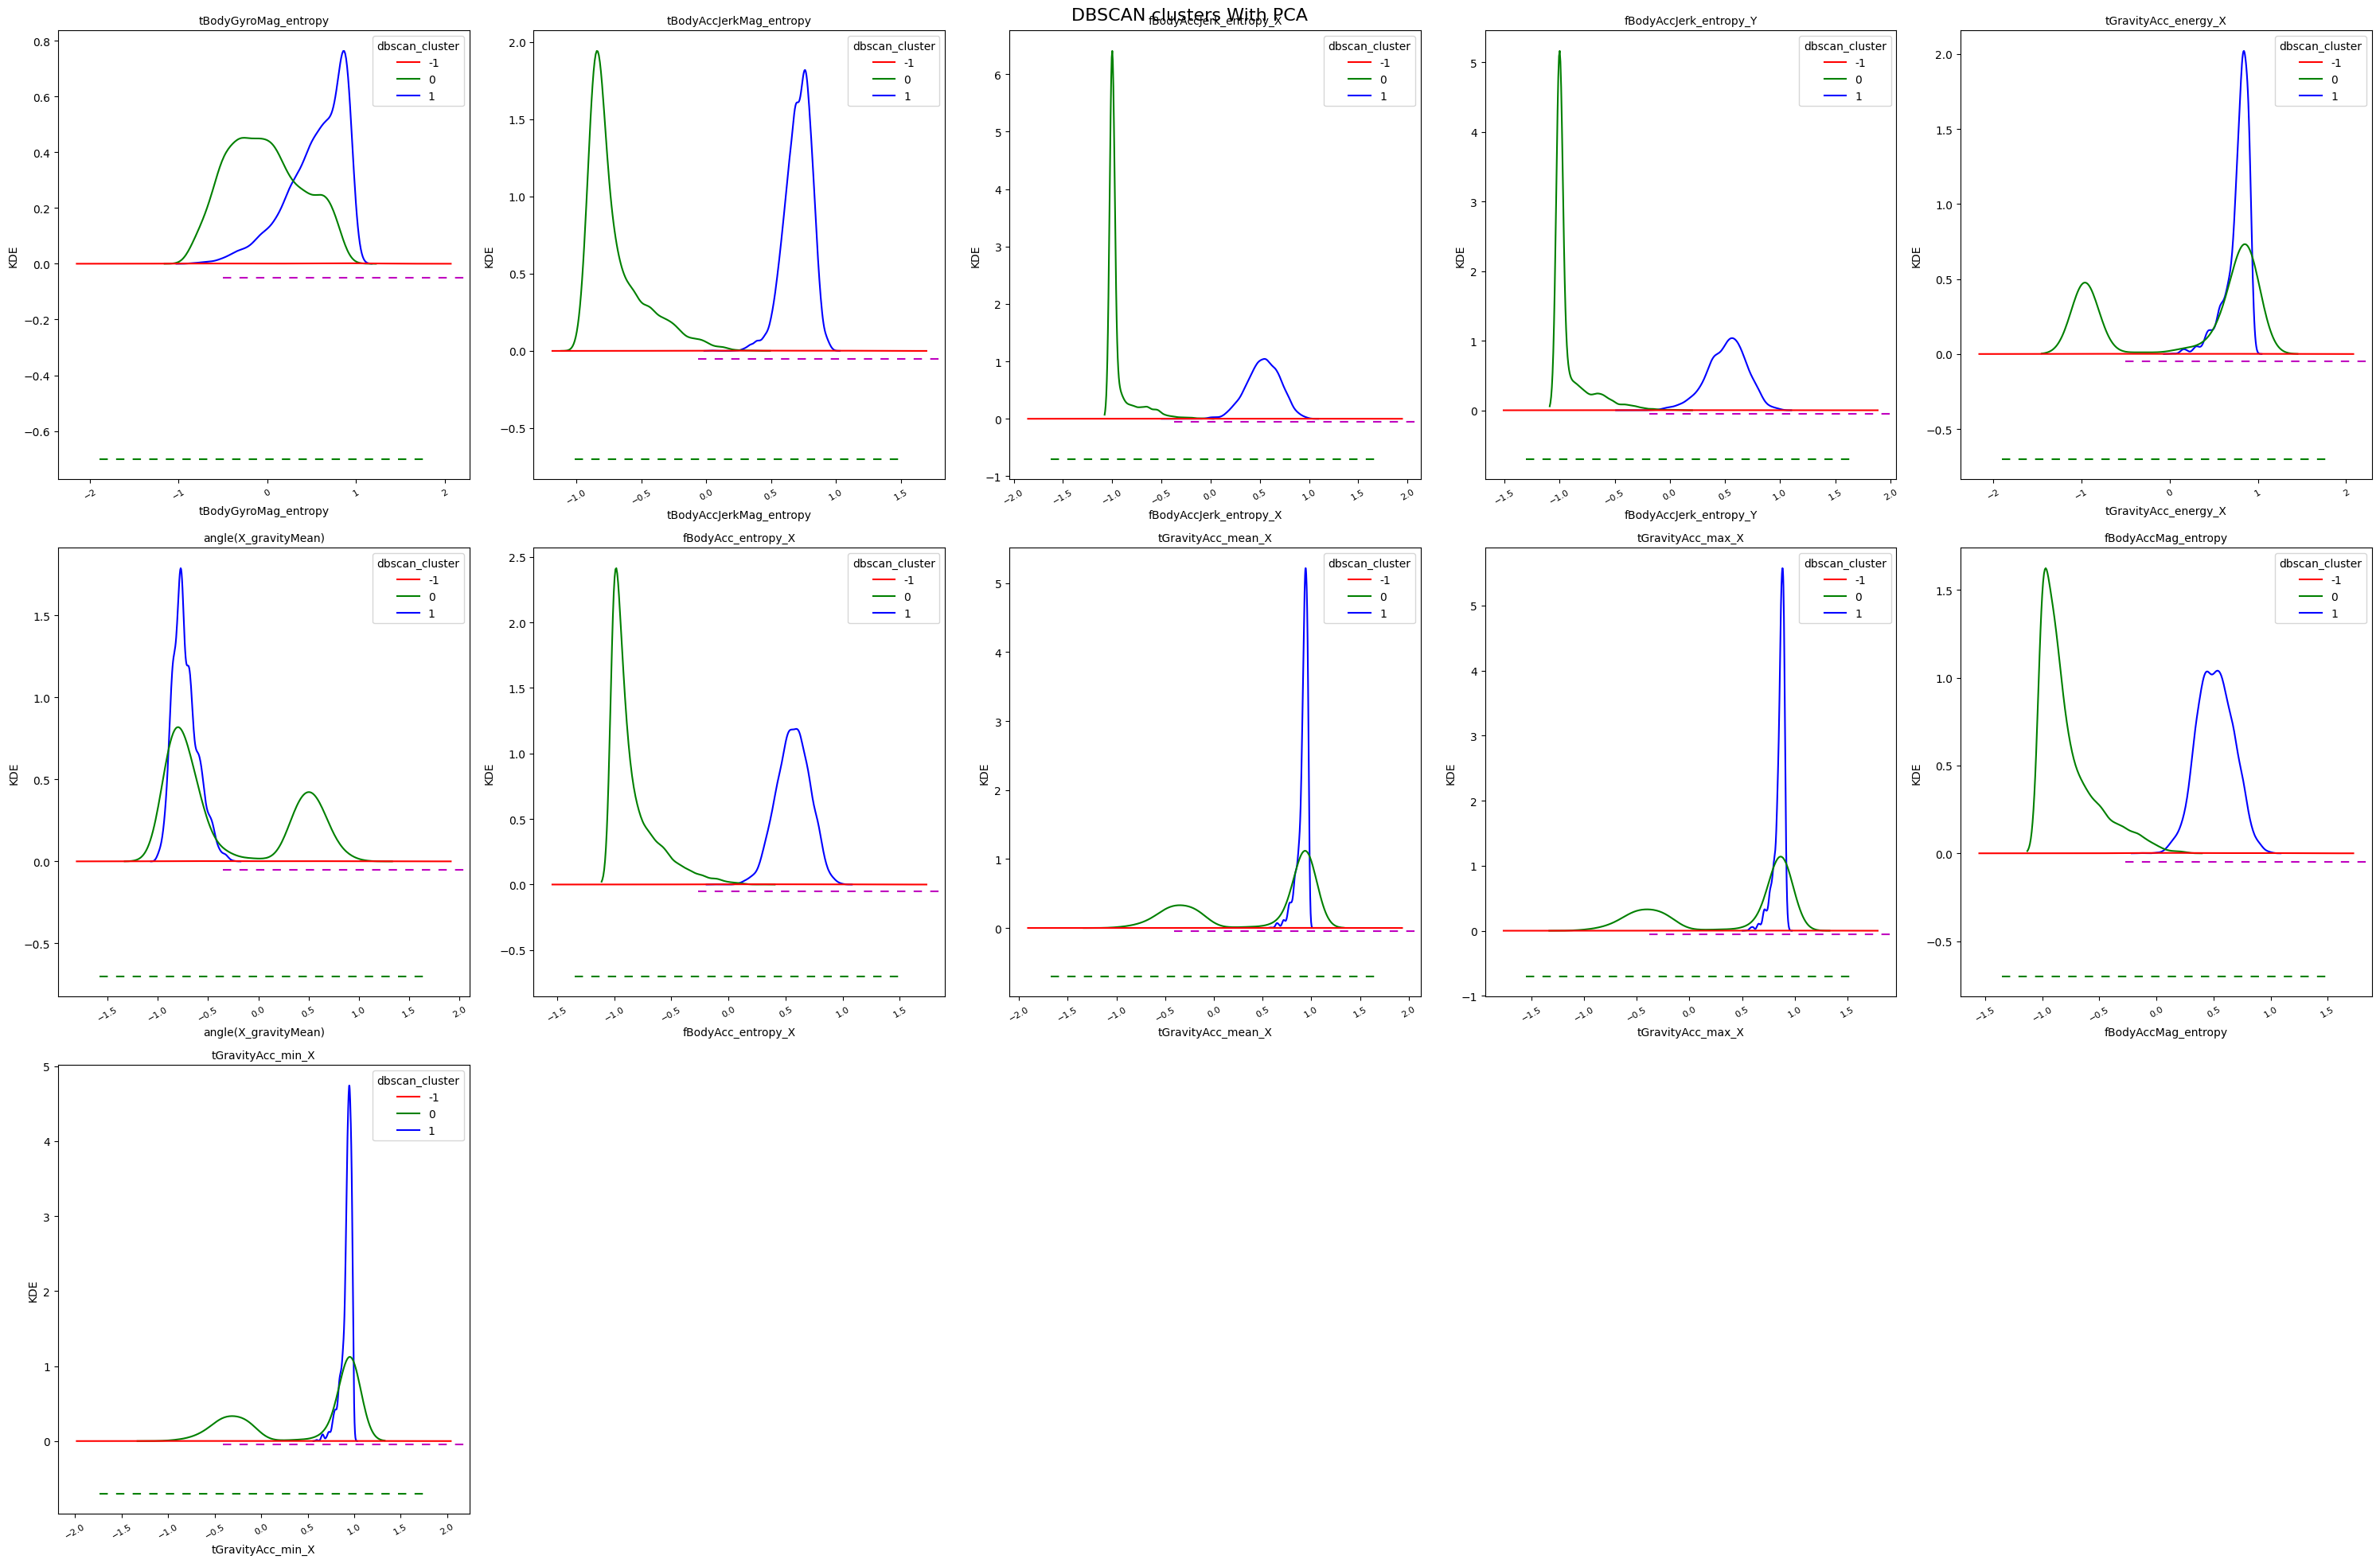

In [85]:
df_final_features = list(df_final.columns)
n_rows = 3
n_cols = 5
custom_colors = {0: 'green', 1: 'blue', -1:'red'}
plt.figure(figsize=(30,20))
plt.suptitle('DBSCAN clusters With PCA', fontsize=16)

for i,col in enumerate(vis_features,1):
  plt.subplot(n_rows, n_cols, i)
  sns.kdeplot(data=df_final, x=col, hue=df_pca_2['dbscan_cluster'], palette=custom_colors)
  plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
  plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
  plt.title(f"{col}", fontsize = 10)
  plt.xlabel(f"{col}", size=10)
  plt.ylabel(f'KDE', size=10)
  plt.xticks(rotation=30, fontsize=8)
  plt.tight_layout()
plt.show()

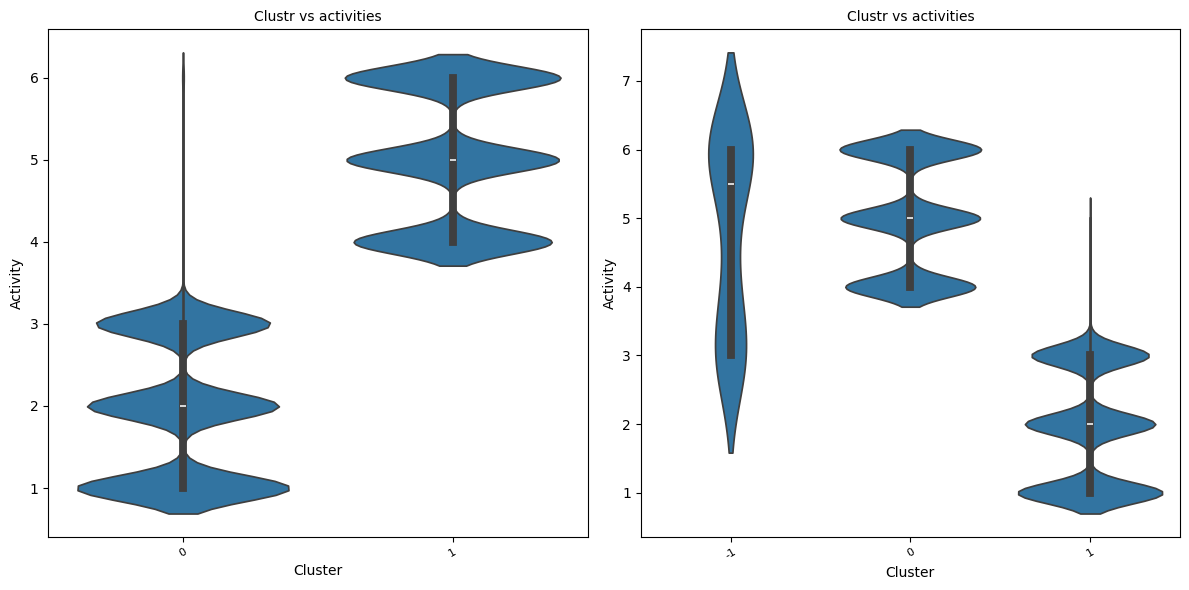

In [86]:
plt.figure(figsize=(12, 6))

# Subplot for the number of clusters
plt.subplot(1, 2, 1)
sns.violinplot(y=full_data_y['label_'], x=df_pca_2['kmeans_cluster'])
plt.title(f"Clustr vs activities", fontsize = 10)
plt.xlabel("Cluster", size=10)
plt.ylabel(f'Activity', size=10)
plt.xticks(rotation=30, fontsize=8)


plt.subplot(1, 2, 2)
sns.violinplot(y=full_data_y['label_'], x=df_pca_2['dbscan_cluster'])

plt.title(f"Clustr vs activities", fontsize = 10)
plt.xlabel("Cluster", size=10)
plt.ylabel(f'Activity', size=10)
plt.xticks(rotation=30, fontsize=8)
plt.tight_layout()

plt.show()

## Conclusion

This project successfully clustered the human activity recognition dataset using KMeans and DBSCAN algorithms. The performance of the models were using the raw features were then compared with clustering using PCA of the datasets. It was observed that the models trained faster with the PCA dataset than with the raw dataset and similar clusters was obtained for both algorithms using the raw features and PCA dataset. This show that no information was lost and PCA is a good tool for dimensionality reduction for datasets with a high dimension. In addition, the model trained on PCA identified fewer outliers than the model trained on the raw data.

Overall, the KMeans algorithm performed better than the DBSCAN algorithm, this can be attributed to its inability to generalized well when the density of the cluster is different, and the dataset is sparse.
The two clusters identified by both algorithms in the two scenarios can be termed as stationary activities (laying, sitting, and standing) and no-stationary activities (Walking).

These two clusters shows that the dataset can be used to differentiate when the subject is walking and when they are stationary from the measurement obtained from the accelerometer and gyroscope of a smartphone.

A major issue encountered during the implementation was the inability of DBSCAN to find clusters within the full dataset. To overcome this dimensionality reduction using feature selection was used for the first experiments without PCA.

Another challenge was the selection of hyperparameters for both KMeans and DBSAN. This were resolved by carrying out hyper parameter tuning and analysis using the elbow method.



### Dataset Source
Jorge L. Reyes-Ortiz(1,2), Davide Anguita(1), Alessandro Ghio(1), Luca Oneto(1) and Xavier Parra(2)
1 - Smartlab - Non-Linear Complex Systems Laboratory
DITEN - Università  degli Studi di Genova, Genoa (I-16145), Italy.
2 - CETpD - Technical Research Centre for Dependency Care and Autonomous Living
Universitat Politècnica de Catalunya (BarcelonaTech). Vilanova i la Geltrú (08800), Spain
activityrecognition '@' smartlab.ws